### Шаг 1. Подготовка окружения в Google Colab и настройка доступа к Kaggle

На этом шаге мы настраиваем рабочее окружение для экспериментов:

1. Создаём базовую структуру проекта в каталоге Colab (`/content/computer_lab_detector`).
2. Устанавливаем необходимые библиотеки:
   * `ultralytics` — реализация моделей YOLOv8;
   * `kaggle` — для работы с Kaggle API и скачивания датасетов;
   * базовые утилиты для анализа данных и работы с изображениями (`numpy`, `pandas`, `matplotlib`, `opencv-python` и др.).
3. Настраиваем доступ к Kaggle через `kaggle.json`, загружая файл с помощью `files.upload()` напрямую в Colab (без Google Drive).
4. Проверяем, что Kaggle API работает (вывод версии и тестовый поиск датасета LabEquipVis).

После выполнения всех ячеек этого шага окружение будет готово для скачивания и предварительной обработки датасетов.

In [1]:
# Базовая настройка проекта и проверка версии Python

import os
import sys
from pathlib import Path

# Базовая директория проекта внутри Colab
PROJECT_ROOT = Path("/content") / "computer_lab_detector"

# Подкаталоги для данных и моделей
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
RUNS_DIR = PROJECT_ROOT / "runs"

# Создаём директории, если их ещё нет
for p in [PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR, RUNS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Python version: {sys.version}")

# На всякий случай переходим в корень проекта
os.chdir(PROJECT_ROOT)
print("Текущая рабочая директория:", os.getcwd())

PROJECT_ROOT: /content/computer_lab_detector
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Текущая рабочая директория: /content/computer_lab_detector


In [2]:
# Установка необходимых библиотек (YOLOv8, Kaggle и утилиты)

# Флаг quiet=-q уменьшает шум от pip, но при необходимости можно убрать, чтобы видеть полный лог.
!pip install -q ultralytics kaggle opencv-python matplotlib pandas numpy tqdm

# Быстрая проверка, что ultralytics установился
from ultralytics import YOLO

print("Ultralytics YOLO успешно импортирован.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics YOLO успешно импортирован.


In [3]:
# Загрузка kaggle.json через files.upload() и настройка Kaggle API
import os
from google.colab import files

# Загружаем kaggle.json вручную с локального компьютера
print("Выберите файл kaggle.json (скачанный с вашего аккаунта Kaggle).")
uploaded_files = files.upload()

if "kaggle.json" not in uploaded_files:
    raise RuntimeError(
        "Файл kaggle.json не найден среди загруженных. "
        "Убедитесь, что выбрали правильный файл и повторите загрузку."
    )

# Создаём каталог для конфигурации Kaggle
kaggle_dir = Path("/root/.kaggle")
kaggle_dir.mkdir(parents=True, exist_ok=True)

kaggle_config_path = kaggle_dir / "kaggle.json"

# Сохраняем загруженный kaggle.json в /root/.kaggle
with open(kaggle_config_path, "wb") as f:
    f.write(uploaded_files["kaggle.json"])

# Ограничиваем права доступа к файлу (обязательно для Kaggle API)
os.chmod(kaggle_config_path, 0o600)

# На всякий случай укажем путь к конфигу через переменную окружения
os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_dir)

print("kaggle.json успешно сохранён в", kaggle_config_path)

Выберите файл kaggle.json (скачанный с вашего аккаунта Kaggle).


Saving kaggle.json to kaggle.json
kaggle.json успешно сохранён в /root/.kaggle/kaggle.json


In [4]:
# Проверка работы Kaggle API

# Проверим, что kaggle установлен и видит наш конфиг
!kaggle --version

print("\nПробуем найти датасет LabEquipVis на Kaggle (по ключевому слову 'labequipvis'):")
!kaggle datasets list -s "labequipvis" | head -n 10

Kaggle API 1.7.4.5

Пробуем найти датасет LabEquipVis на Kaggle (по ключевому слову 'labequipvis'):
ref                                                          title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
bmshahriaalam/labequipvis-dataset-of-computer-lab-equipment  LabEquipVis: Dataset of Computer Lab Equipment   630434358  2025-08-18 13:08:34.917000             46          5  1.0              


### Шаг 2. Загрузка и первичная организация датасетов LabEquipVis и E-Waste

На этом шаге мы:

1. Скачиваем два датасета с Kaggle при помощи Kaggle CLI:
   * **LabEquipVis: Dataset of Computer Lab Equipment** — изображения компьютерных лабораторий с разметкой в формате YOLO.
   * **E Waste Image Dataset** (`akshat103/e-waste-image-dataset`) — изображения 10 типов электронных устройств, разложенные по папкам классов внутри директорий `train`, `val`, `test` в подпапке `modified-dataset`.
2. Распаковываем архивы в подкаталоги `data/raw/labequipvis/` и `data/raw/e_waste_image_dataset/`.
3. Выполняем быстрый «sanity check»:
   * для **LabEquipVis** подсчитываем количество изображений и файлов разметки (`.txt`);
   * для **E-waste** выводим список классов и количество изображений в каждом сплите (`train`, `val`, `test`) из `modified-dataset`.

Это подготовит «сырой» слой данных (`raw`), который затем будет конвертирован в единый формат YOLO для общего датасета «компьютерные классы».


In [8]:
# Конфигурация путей и вспомогательные функции

import os
from pathlib import Path
import zipfile

# Если проект не инициализировали на шаге 1 (или запущен новый сеанс), создаём пути заново
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path("/content") / "computer_lab_detector"
    RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
    PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
    MODELS_DIR = PROJECT_ROOT / "models"
    RUNS_DIR = PROJECT_ROOT / "runs"

    for p in [PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR, RUNS_DIR]:
        p.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DATA_DIR:", RAW_DATA_DIR)

# Описание используемых датасетов
DATASETS = {
    "labequipvis": {
        "kaggle_id": "bmshahriaalam/labequipvis-dataset-of-computer-lab-equipment",
        "root_dir": RAW_DATA_DIR / "labequipvis",
    },
    "ewaste": {
        "kaggle_id": "akshat103/e-waste-image-dataset",
        "root_dir": RAW_DATA_DIR / "e_waste_image_dataset",
    },
}


def download_and_unzip_kaggle_dataset(kaggle_id: str, target_dir: Path, force_download: bool = False):
    """
    Скачивает датасет с Kaggle и распаковывает архив в целевую директорию.

    kaggle_id      — строка формата "owner/dataset-name"
    target_dir     — путь, куда сложить zip и распакованный контент
    force_download — если True, перекачивает архив даже если он уже есть
    """
    target_dir = Path(target_dir)
    target_dir.mkdir(parents=True, exist_ok=True)

    slug = kaggle_id.split("/")[-1]
    zip_path = target_dir / f"{slug}.zip"

    if force_download or not zip_path.exists():
        print(f"\n=== Скачиваем {kaggle_id} в {target_dir} ===")
        exit_code = os.system(
            f'kaggle datasets download -d {kaggle_id} -p "{target_dir}" --force'
        )
        if exit_code != 0:
            raise RuntimeError(
                f"Ошибка при скачивании датасета {kaggle_id}. "
                "Проверьте доступность датасета и настройки Kaggle."
            )
        if not zip_path.exists():
            # если вдруг архив назван иначе — берём первый попавшийся .zip
            zips = list(target_dir.glob("*.zip"))
            if not zips:
                raise RuntimeError(
                    f"После скачивания не найден zip-файл в {target_dir}."
                )
            zip_path = zips[0]

    print(f"Архив найден: {zip_path.name}")

    print(f"Распаковываем архив в {target_dir} ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(target_dir)

    print("Распаковка завершена.")


def show_dir_tree(root: Path, max_depth: int = 2, max_files_per_dir: int = 5):
    """
    Красивый вывод структуры каталогов (ограниченной глубины),
    чтобы не захламлять вывод десятками тысяч строк.
    """
    root = Path(root)
    print(f"\nСтруктура каталога: {root}")
    root_depth = len(root.parts)

    for current_root, dirs, files in os.walk(root):
        current_path = Path(current_root)
        depth = len(current_path.parts) - root_depth
        if depth > max_depth:
            continue

        indent = "  " * depth
        print(f"{indent}{current_path.name}/")

        files_sorted = sorted(files)
        for fname in files_sorted[:max_files_per_dir]:
            print(f"{indent}  {fname}")
        if len(files_sorted) > max_files_per_dir:
            print(f"{indent}  ... и ещё {len(files_sorted) - max_files_per_dir} файлов")

    print("—" * 60)


def find_split_dirs_recursive(root: Path):
    """
    Рекурсивно ищет директории train / val / test (без учёта регистра)
    и возвращает словарь {имя_сплита: Path}.
    """
    root = Path(root)
    split_dirs = {}
    target_names = {"train", "test", "val", "valid", "validation"}

    for current_root, dirs, files in os.walk(root):
        for d in dirs:
            name_lower = d.lower()
            if name_lower in target_names:
                split_dirs[name_lower] = Path(current_root) / d

    return split_dirs

PROJECT_ROOT: /content/computer_lab_detector
RAW_DATA_DIR: /content/computer_lab_detector/data/raw


In [9]:
# Скачивание и первичный осмотр LabEquipVis
lab_cfg = DATASETS["labequipvis"]
lab_root = lab_cfg["root_dir"]

download_and_unzip_kaggle_dataset(
    kaggle_id=lab_cfg["kaggle_id"],
    target_dir=lab_root,
    force_download=False,
)

show_dir_tree(lab_root, max_depth=3, max_files_per_dir=5)

# Быстрый подсчёт количества изображений и файлов разметки (.txt)
image_exts = {".jpg", ".jpeg", ".png", ".bmp"}
num_images = 0
num_label_txt = 0

for current_root, dirs, files in os.walk(lab_root):
    for fname in files:
        ext = Path(fname).suffix.lower()
        if ext in image_exts:
            num_images += 1
        elif ext == ".txt":
            num_label_txt += 1

print(f"\nLabEquipVis: найдено изображений: {num_images}, файлов разметки (.txt): {num_label_txt}")

Архив найден: labequipvis-dataset-of-computer-lab-equipment.zip
Распаковываем архив в /content/computer_lab_detector/data/raw/labequipvis ...
Распаковка завершена.

Структура каталога: /content/computer_lab_detector/data/raw/labequipvis
labequipvis/
  labequipvis-dataset-of-computer-lab-equipment.zip
  readme.pdf
  Augmented Data/
    data.yaml
    test/
      images/
        VID20250409130240_mp4-0000_jpg.rf.312ea5df741f83a85a5c62da6fe5b662.jpg
        VID20250409130240_mp4-0000_jpg.rf.312ea5df741f83a85a5c62da6fe5b662_aug1.jpg
        VID20250409130240_mp4-0000_jpg.rf.312ea5df741f83a85a5c62da6fe5b662_aug2.jpg
        VID20250409130240_mp4-0020_jpg.rf.9270706544e3ef7734128d69ead90d1f.jpg
        VID20250409130240_mp4-0020_jpg.rf.9270706544e3ef7734128d69ead90d1f_aug1.jpg
        ... и ещё 772 файлов
      labels/
        VID20250409130240_mp4-0000_jpg.rf.312ea5df741f83a85a5c62da6fe5b662.txt
        VID20250409130240_mp4-0000_jpg.rf.312ea5df741f83a85a5c62da6fe5b662_aug1.txt
        VID20

In [10]:
# Скачивание и первичный осмотр E Waste Image Dataset
ew_cfg = DATASETS["ewaste"]
ew_root = ew_cfg["root_dir"]

download_and_unzip_kaggle_dataset(
    kaggle_id=ew_cfg["kaggle_id"],
    target_dir=ew_root,
    force_download=False,
)

# В этом датасете все нужные сплиты лежат в подпапке modified-dataset
ew_modified_root = ew_root / "modified-dataset"
if not ew_modified_root.exists():
    print(
        "\nПапка modified-dataset не найдена, покажем общую структуру датасета "
        "и остановимся, чтобы не накосячить."
    )
    show_dir_tree(ew_root, max_depth=4, max_files_per_dir=5)
else:
    print("\nИспользуем корень E-waste датасета:", ew_modified_root)
    show_dir_tree(ew_modified_root, max_depth=3, max_files_per_dir=5)

    # Ищем директории train / val / test рекурсивно
    split_dirs = find_split_dirs_recursive(ew_modified_root)

    if not split_dirs:
        print("\nНе удалось найти директории train/val/test даже рекурсивно. Проверьте структуру вручную.")
    else:
        print("\nНайдены директории сплитов E-waste (modified-dataset):")
        for split_name, split_path in split_dirs.items():
            print(f"  {split_name} -> {split_path}")

        # Для каждого сплита выводим список классов и количество изображений по классам
        image_exts = {".jpg", ".jpeg", ".png", ".bmp"}

        for split_name, split_path in split_dirs.items():
            print(f"\n=== Сплит: {split_name} ===")
            # Внутри сплита лежат папки классов
            classes = [d for d in split_path.iterdir() if d.is_dir()]
            if not classes:
                print("  В этом сплите не найдены подкаталоги классов.")
                continue

            class_counts = {}
            for class_dir in sorted(classes, key=lambda p: p.name):
                count = 0
                for fname in class_dir.iterdir():
                    if fname.is_file() and fname.suffix.lower() in image_exts:
                        count += 1
                class_counts[class_dir.name] = count

            total_images = sum(class_counts.values())
            print(f"  Всего изображений в сплите: {total_images}")
            print("  Классы и количество изображений:")
            for cls_name, cls_count in class_counts.items():
                print(f"    {cls_name}: {cls_count}")

Архив найден: e-waste-image-dataset.zip
Распаковываем архив в /content/computer_lab_detector/data/raw/e_waste_image_dataset ...
Распаковка завершена.

Используем корень E-waste датасета: /content/computer_lab_detector/data/raw/e_waste_image_dataset/modified-dataset

Структура каталога: /content/computer_lab_detector/data/raw/e_waste_image_dataset/modified-dataset
modified-dataset/
  test/
    Microwave/
      Microwave_106.jpg
      Microwave_128.jpg
      Microwave_148.jpg
      Microwave_152.jpg
      Microwave_174.jpg
      ... и ещё 25 файлов
    Mobile/
      Mobile_106.jpg
      Mobile_128.jpg
      Mobile_148.jpg
      Mobile_152.jpg
      Mobile_174.jpg
      ... и ещё 25 файлов
    Keyboard/
      Keyboard_106.jpg
      Keyboard_128.jpg
      Keyboard_148.jpg
      Keyboard_152.jpg
      Keyboard_174.jpg
      ... и ещё 25 файлов
    Television/
      Television_106.jpg
      Television_128.jpg
      Television_148.jpg
      Television_152.jpg
      Television_174.jpg
      ..

### Шаг 3. Приведение LabEquipVis и E-waste к общему YOLO-формату и сбор «совмещенного» датасета

На этом шаге мы:

1. Читаем `data.yaml` из **LabEquipVis (Augmented Data)** и извлекаем список классов.
2. Сканируем **E-waste** (`modified-dataset`) и берём названия классов из папок (`Battery`, `Keyboard`, `Mouse`, …).
3. Приводим имена классов к единому «каноническому» виду (нижний регистр, подчёркивания вместо пробелов) и строим общий словарь классов.
   * Классы LabEquipVis идут «базой».
   * Классы E-waste добавляются только если ещё не встречались.
4. Собираем единый датасет в `data/processed/combined_yolo/` в формате YOLOv8:
   * `images/train`, `images/val`, `images/test`
   * `labels/train`, `labels/val`, `labels/test`
   * для **LabEquipVis**:
     * копируем изображения из `Augmented Data/train|valid|test/images`;
     * переписываем разметку из `labels`, переиндексируя классы в соответствии с новым словарём;
     * префикс имён файлов: `lab_…`.
   * для **E-waste**:
     * для каждого изображения в папке класса создаём один бокс на весь кадр (`0.5 0.5 1.0 1.0`);
     * класс берём из папки, переиндексируем по общему словарю;
     * префикс имён файлов: `ew_…`.
5. Создаём `data.yaml` для совмещённого датасета и выводим сводную статистику по сплитам.

Этот шаг даёт готовый объединённый набор данных, с которым уже можно обучать YOLOv8.


In [11]:
# Импорт и подготовка: общие классы, чтение data.yaml LabEquipVis, классы E-waste

# Устанавливаем PyYAML, если ещё не установлен
!pip install -q pyyaml

import os
from pathlib import Path
import shutil
from collections import defaultdict
import yaml

# Базовые пути (на случай, если ядро перезапускали)
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path("/content") / "computer_lab_detector"

RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
COMBINED_ROOT = PROCESSED_DATA_DIR / "combined_yolo"

LAB_ROOT = RAW_DATA_DIR / "labequipvis"
LAB_AUG_ROOT = LAB_ROOT / "Augmented Data"  # используем аугментированный набор
EW_ROOT = RAW_DATA_DIR / "e_waste_image_dataset"
EW_MOD_ROOT = EW_ROOT / "modified-dataset"

for p in [PROCESSED_DATA_DIR, COMBINED_ROOT]:
    p.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DATA_DIR:", RAW_DATA_DIR)
print("COMBINED_ROOT:", COMBINED_ROOT)


def canonical_name(name: str) -> str:
    """
    Приводит имя класса к каноническому виду:
    - обрезает пробелы по краям
    - заменяет пробелы и дефисы на подчёркивания
    - переводит в нижний регистр
    """
    name = name.strip()
    name = name.replace(" ", "_").replace("-", "_")
    return name.lower()


# ---------- 1. Классы LabEquipVis (из data.yaml) ----------

lab_yaml_path = LAB_AUG_ROOT / "data.yaml"
if not lab_yaml_path.exists():
    raise FileNotFoundError(f"Не найден data.yaml LabEquipVis по пути {lab_yaml_path}")

with open(lab_yaml_path, "r") as f:
    lab_yaml = yaml.safe_load(f)

lab_names_raw = lab_yaml.get("names")
if lab_names_raw is None:
    raise ValueError("В LabEquipVis data.yaml не найден ключ 'names'.")

# В YOLO data.yaml names может быть списком или словарём {id: name}
if isinstance(lab_names_raw, dict):
    # сортируем по индексу класса
    lab_class_names = [lab_names_raw[k] for k in sorted(lab_names_raw.keys(), key=int)]
else:
    lab_class_names = list(lab_names_raw)

print("\nКлассы LabEquipVis (как в data.yaml):")
for idx, name in enumerate(lab_class_names):
    print(f"  {idx}: {name}")

# Строим общий словарь классов, начиная с LabEquipVis
canonical_to_idx = {}
final_class_names = []  # имена классов по новым индексам (для общего data.yaml)
lab_index_map = {}      # сопоставление: старый индекс LabEquipVis -> новый индекс

for old_idx, name in enumerate(lab_class_names):
    c = canonical_name(name)
    if c in canonical_to_idx:
        new_idx = canonical_to_idx[c]
    else:
        new_idx = len(final_class_names)
        canonical_to_idx[c] = new_idx
        final_class_names.append(c)
    lab_index_map[old_idx] = new_idx

print("\nСоответствие индексов LabEquipVis -> объединённые классы:")
for old_idx, name in enumerate(lab_class_names):
    c = canonical_name(name)
    print(f"  Lab {old_idx}: {name} -> {c} -> new_id={lab_index_map[old_idx]}")

# ---------- 2. Классы E-waste (из имён папок в modified-dataset/train) ----------

if not EW_MOD_ROOT.exists():
    raise FileNotFoundError(f"Не найдена папка modified-dataset по пути {EW_MOD_ROOT}")

ew_train_root = EW_MOD_ROOT / "train"
if not ew_train_root.exists():
    raise FileNotFoundError(f"Не найдена папка train в {EW_MOD_ROOT}")

# при желании можно ограничить список подключаемых классов E-waste:
# например, только компьютерные: {"Keyboard", "Mouse", "Printer"}
EWASTE_INCLUDED_CLASSES = None  # или set([...])

ew_name_to_final_idx = {}

ew_class_dirs = sorted([d for d in ew_train_root.iterdir() if d.is_dir()],
                       key=lambda p: p.name)

print("\nКлассы E-waste (по папкам в train):")
for class_dir in ew_class_dirs:
    orig_name = class_dir.name
    if EWASTE_INCLUDED_CLASSES is not None and orig_name not in EWASTE_INCLUDED_CLASSES:
        print(f"  [Пропускаем] {orig_name}")
        continue

    c = canonical_name(orig_name)
    if c in canonical_to_idx:
        new_idx = canonical_to_idx[c]
    else:
        new_idx = len(final_class_names)
        canonical_to_idx[c] = new_idx
        final_class_names.append(c)

    ew_name_to_final_idx[orig_name] = new_idx
    print(f"  {orig_name} -> {c} -> new_id={new_idx}")

print("\nИтоговый список классов (объединённый):")
for i, name in enumerate(final_class_names):
    print(f"  {i}: {name}")
print(f"Всего классов: {len(final_class_names)}")

PROJECT_ROOT: /content/computer_lab_detector
RAW_DATA_DIR: /content/computer_lab_detector/data/raw
COMBINED_ROOT: /content/computer_lab_detector/data/processed/combined_yolo

Классы LabEquipVis (как в data.yaml):
  0: Ac
  1: Chair
  2: Cpu
  3: Digital board
  4: Fire Extinguisher
  5: Keyboard
  6: Light
  7: Monitor
  8: Mouse
  9: Projector

Соответствие индексов LabEquipVis -> объединённые классы:
  Lab 0: Ac -> ac -> new_id=0
  Lab 1: Chair -> chair -> new_id=1
  Lab 2: Cpu -> cpu -> new_id=2
  Lab 3: Digital board -> digital_board -> new_id=3
  Lab 4: Fire Extinguisher -> fire_extinguisher -> new_id=4
  Lab 5: Keyboard -> keyboard -> new_id=5
  Lab 6: Light -> light -> new_id=6
  Lab 7: Monitor -> monitor -> new_id=7
  Lab 8: Mouse -> mouse -> new_id=8
  Lab 9: Projector -> projector -> new_id=9

Классы E-waste (по папкам в train):
  Battery -> battery -> new_id=10
  Keyboard -> keyboard -> new_id=5
  Microwave -> microwave -> new_id=11
  Mobile -> mobile -> new_id=12
  Mouse ->

In [12]:
# Формирование объединённого датасета YOLO: копирование изображений и генерация разметки
from collections import defaultdict

# Создаём структуру каталогов для объединённого датасета
for split in ["train", "val", "test"]:
    (COMBINED_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (COMBINED_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

image_exts = {".jpg", ".jpeg", ".png", ".bmp"}

combined_stats = {
    "lab": defaultdict(int),
    "ewaste": defaultdict(int),
}

# ---------- 1. Копирование и переиндексация LabEquipVis (Augmented Data) ----------

lab_split_map = {
    "train": "train",
    "valid": "val",   # valid -> val
    "test": "test",
}

print("\n=== Перенос LabEquipVis (Augmented Data) ===")

for src_split, dst_split in lab_split_map.items():
    src_img_dir = LAB_AUG_ROOT / src_split / "images"
    src_lbl_dir = LAB_AUG_ROOT / src_split / "labels"

    dst_img_dir = COMBINED_ROOT / "images" / dst_split
    dst_lbl_dir = COMBINED_ROOT / "labels" / dst_split

    if not src_img_dir.exists():
        print(f"  [Пропуск] Нет каталога изображений {src_img_dir}")
        continue

    img_files = sorted([p for p in src_img_dir.iterdir()
                        if p.is_file() and p.suffix.lower() in image_exts])

    print(f"  Сплит {src_split} -> {dst_split}: найдено {len(img_files)} изображений.")

    for img_path in img_files:
        stem = img_path.stem
        src_label_path = src_lbl_dir / f"{stem}.txt"
        if not src_label_path.exists():
            # На всякий случай защищаемся от рассинхронизации
            # (в этом датасете такого быть не должно)
            # Можно вывести предупреждение и пропустить изображение
            # print(f"    [WARN] Для {img_path.name} не найден label {src_label_path.name}")
            continue

        new_stem = f"lab_{stem}"
        dst_img_path = dst_img_dir / f"{new_stem}{img_path.suffix.lower()}"
        dst_label_path = dst_lbl_dir / f"{new_stem}.txt"

        # Копируем изображение
        shutil.copy2(img_path, dst_img_path)

        # Переписываем разметку с переиндексацией классов
        with open(src_label_path, "r") as f_in, open(dst_label_path, "w") as f_out:
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                old_cls = int(parts[0])
                new_cls = lab_index_map[old_cls]
                rest = parts[1:]
                f_out.write(" ".join([str(new_cls)] + rest) + "\n")

        combined_stats["lab"][dst_split] += 1

print("Готово перенесён LabEquipVis.")


# ---------- 2. Копирование и генерация разметки для E-waste ----------

print("\n=== Перенос E-waste (modified-dataset) ===")

for split in ["train", "val", "test"]:
    split_dir = EW_MOD_ROOT / split
    if not split_dir.exists():
        print(f"  [Пропуск] Нет каталога сплита {split_dir}")
        continue

    dst_img_dir = COMBINED_ROOT / "images" / split
    dst_lbl_dir = COMBINED_ROOT / "labels" / split

    class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()],
                        key=lambda p: p.name)

    total_images_in_split = 0

    for class_dir in class_dirs:
        orig_name = class_dir.name
        if EWASTE_INCLUDED_CLASSES is not None and orig_name not in EWASTE_INCLUDED_CLASSES:
            # этот класс мы решили не включать
            continue

        if orig_name not in ew_name_to_final_idx:
            # класс не вошёл в итоговый словарь (например, был отфильтрован)
            continue

        cls_idx = ew_name_to_final_idx[orig_name]
        canon_cls_name = canonical_name(orig_name)

        img_files = sorted([p for p in class_dir.iterdir()
                            if p.is_file() and p.suffix.lower() in image_exts])

        for img_path in img_files:
            total_images_in_split += 1
            new_stem = f"ew_{split}_{canon_cls_name}_{img_path.stem}"
            dst_img_path = dst_img_dir / f"{new_stem}{img_path.suffix.lower()}"
            dst_label_path = dst_lbl_dir / f"{new_stem}.txt"

            # Копируем изображение
            shutil.copy2(img_path, dst_img_path)

            # Для классификационного датасета делаем один бокс на весь кадр:
            # x_center=0.5, y_center=0.5, width=1.0, height=1.0
            with open(dst_label_path, "w") as f_out:
                f_out.write(f"{cls_idx} 0.5 0.5 1.0 1.0\n")

            combined_stats["ewaste"][split] += 1

    print(f"  Сплит {split}: перенесено {total_images_in_split} изображений.")

print("Готово перенесён E-waste.")

print("\nСводная статистика по объединённому датасету:")
for src_name, stats in combined_stats.items():
    print(f"Источник: {src_name}")
    for split, count in stats.items():
        print(f"  {split}: {count} изображений")


=== Перенос LabEquipVis (Augmented Data) ===
  Сплит train -> train: найдено 5427 изображений.
  Сплит valid -> val: найдено 1548 изображений.
  Сплит test -> test: найдено 777 изображений.
Готово перенесён LabEquipVis.

=== Перенос E-waste (modified-dataset) ===
  Сплит train: перенесено 2400 изображений.
  Сплит val: перенесено 300 изображений.
  Сплит test: перенесено 300 изображений.
Готово перенесён E-waste.

Сводная статистика по объединённому датасету:
Источник: lab
  train: 5427 изображений
  val: 1548 изображений
  test: 777 изображений
Источник: ewaste
  train: 2400 изображений
  val: 300 изображений
  test: 300 изображений


In [13]:
# Создание общего data.yaml и финальная проверка
import yaml

combined_yaml_path = COMBINED_ROOT / "data.yaml"

data_yaml = {
    "path": str(COMBINED_ROOT.resolve()),
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "nc": len(final_class_names),
    # YOLO допускает как список, так и dict; сделаем dict {id: name}
    "names": {i: name for i, name in enumerate(final_class_names)},
}

with open(combined_yaml_path, "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False, allow_unicode=True)

print("data.yaml для объединённого датасета сохранён по пути:")
print(combined_yaml_path)

print("\nИтоговый список классов:")
for i, name in enumerate(final_class_names):
    print(f"  {i}: {name}")

# Быстрая проверка количества файлов в каждом сплите
def count_files_in_dir(root: Path, ext_set):
    root = Path(root)
    count = 0
    if not root.exists():
        return 0
    for p in root.iterdir():
        if p.is_file() and p.suffix.lower() in ext_set:
            count += 1
    return count

print("\nПроверка количества изображений в объединённом датасете:")
for split in ["train", "val", "test"]:
    img_dir = COMBINED_ROOT / "images" / split
    lbl_dir = COMBINED_ROOT / "labels" / split
    n_img = count_files_in_dir(img_dir, {".jpg", ".jpeg", ".png", ".bmp"})
    n_lbl = count_files_in_dir(lbl_dir, {".txt"})
    print(f"  {split}: {n_img} изображений, {n_lbl} файлов разметки")

data.yaml для объединённого датасета сохранён по пути:
/content/computer_lab_detector/data/processed/combined_yolo/data.yaml

Итоговый список классов:
  0: ac
  1: chair
  2: cpu
  3: digital_board
  4: fire_extinguisher
  5: keyboard
  6: light
  7: monitor
  8: mouse
  9: projector
  10: battery
  11: microwave
  12: mobile
  13: pcb
  14: player
  15: printer
  16: television
  17: washing_machine

Проверка количества изображений в объединённом датасете:
  train: 7827 изображений, 7827 файлов разметки
  val: 1848 изображений, 1848 файлов разметки
  test: 1077 изображений, 1077 файлов разметки


### Шаг 4. Базовое обучение YOLOv8n на объединённом датасете

На этом шаге мы:

1. Подгружаем путь к объединённому датасету `combined_yolo/data.yaml` и проверяем список классов.
2. Запускаем обучение модели **YOLOv8n** (лёгкий вариант) на объединённом датасете:
   * используем предобученные веса `yolov8n.pt` (обучение с дообучением, а не «с нуля»);
   * задаём размер изображения `640`, количество эпох (по умолчанию 50) и размер батча;
   * включаем раннюю остановку по `patience`, чтобы не тратить лишнее GPU-время в Colab.
3. После обучения:
   * берём **best-weights** модели;
   * валидируем её отдельно на `test`-сплите совмещённого датасета;
   * сохраняем веса в папку `models/` и визуализируем несколько примеров предсказаний из `test`.

При необходимости параметры обучения (число эпох, размер батча, imgsz и т.п.) можно позже подправить под ограничения конкретной сессии Colab.

In [14]:
# Подготовка: пути, загрузка data.yaml, проверка классов
from pathlib import Path
import yaml
import torch

# Базовые пути (на случай перезапуска ядра)
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path("/content") / "computer_lab_detector"

RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
COMBINED_ROOT = PROCESSED_DATA_DIR / "combined_yolo"
MODELS_DIR = PROJECT_ROOT / "models"
RUNS_DIR = PROJECT_ROOT / "runs"

for p in [MODELS_DIR, RUNS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

combined_yaml_path = COMBINED_ROOT / "data.yaml"
if not combined_yaml_path.exists():
    raise FileNotFoundError(f"Не найден объединённый data.yaml: {combined_yaml_path}")

print("Используем датасет:", combined_yaml_path)

with open(combined_yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml.get("names")
if isinstance(class_names, dict):
    # dict {id: name} -> список по индексу
    class_names_list = [class_names[i] for i in sorted(class_names.keys())]
else:
    class_names_list = list(class_names)

print("\nКлассы датасета:")
for i, name in enumerate(class_names_list):
    print(f"  {i}: {name}")

device = 0 if torch.cuda.is_available() else "cpu"
print("\nCUDA доступна:", torch.cuda.is_available(), "| device:", device)

Используем датасет: /content/computer_lab_detector/data/processed/combined_yolo/data.yaml

Классы датасета:
  0: ac
  1: chair
  2: cpu
  3: digital_board
  4: fire_extinguisher
  5: keyboard
  6: light
  7: monitor
  8: mouse
  9: projector
  10: battery
  11: microwave
  12: mobile
  13: pcb
  14: player
  15: printer
  16: television
  17: washing_machine

CUDA доступна: True | device: 0


In [15]:
# Обучение YOLOv8n на объединённом датасете

from ultralytics import YOLO

# Загружаем предобученную модель YOLOv8n (COCO)
model = YOLO("yolov8n.pt")

# Настройки обучения — при желании подправь epochs / batch
TRAIN_EPOCHS = 50          # можно уменьшить до 30 в слабой сессии
TRAIN_BATCH = 16           # уменьшить до 8, если не хватает памяти
IMG_SIZE = 640

train_results = model.train(
    data=str(combined_yaml_path),   # путь к data.yaml
    imgsz=IMG_SIZE,
    epochs=TRAIN_EPOCHS,
    batch=TRAIN_BATCH,
    workers=2,                      # в Colab достаточно 2, чтобы не ловить баги
    device=device,
    project=str(RUNS_DIR),          # /content/computer_lab_detector/runs
    name="yolov8n_combined_v1",     # имя эксперимента
    exist_ok=True,                  # не ругаться, если папка уже есть
    seed=42,
    patience=15,                    # ранняя остановка по валидации
    verbose=True,
)

print("\nОбучение завершено.")
# В ultralytics после train у модели есть объект trainer с путём к run-директории
run_dir = Path(model.trainer.save_dir)
print("Каталог эксперимента:", run_dir)

best_weights_path = run_dir / "weights" / "best.pt"
print("Путь к лучшим весам:", best_weights_path)

if not best_weights_path.exists():
    raise FileNotFoundError(
        f"best.pt не найден по пути {best_weights_path}. Проверь логи обучения."
    )

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/computer_lab_detector/data/processed/combined_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_combined_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

In [16]:
# Валидация лучшей модели на test-сплите и сохранение весов в models/
from ultralytics import YOLO

# Загружаем лучшую модель по результатам обучения
best_model = YOLO(str(best_weights_path))

# Отдельная оценка на test-сплите объединённого датасета
test_results = best_model.val(
    data=str(combined_yaml_path),
    split="test",
    imgsz=IMG_SIZE,
    batch=TRAIN_BATCH,
    device=device,
    verbose=True,
)

print("\nРезультаты на test-сплите (основные метрики):")
# В новых версиях ultralytics есть поле results_dict
if hasattr(test_results, "results_dict"):
    for k, v in test_results.results_dict.items():
        print(f"  {k}: {v}")
else:
    # fallback — просто вывести объект
    print(test_results)

# Копируем best.pt в папку models для удобства использования во Flask
final_weights_path = MODELS_DIR / "yolov8n_combined_best.pt"
shutil.copy2(best_weights_path, final_weights_path)

print("\nФинальные веса сохранены как:")
print(final_weights_path)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,158 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 385.1±476.9 MB/s, size: 11.4 KB)
val: Scanning /content/computer_lab_detector/data/processed/combined_yolo/labels/test... 1077 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1077/1077 1.4Kit/s 0.8s
val: /content/computer_lab_detector/data/processed/combined_yolo/images/test/lab_VID20250409130921_mp4-0079_jpg.rf.0340245f356288e1056d9030f2da1b89.jpg: 1 duplicate labels removed
val: /content/computer_lab_detector/data/processed/combined_yolo/images/test/lab_VID20250409130921_mp4-0079_jpg.rf.0340245f356288e1056d9030f2da1b89_aug1.jpg: 1 duplicate labels removed
val: /content/computer_lab_detector/data/processed/combined_yolo/images/test/lab_VID20250409130921_mp4-0079_jpg.rf.0340245f356288e1056d9030f2da1b89_aug2.jpg: 1 duplicate labels removed
val: New cache created: /content/c

Покажем примеры предсказаний для 4 тестовых изображений.

Изображение: lab_VID20250415114022_mp4-0050_jpg.rf.d495b06353f8325748013c91ca031a07_aug2.jpg


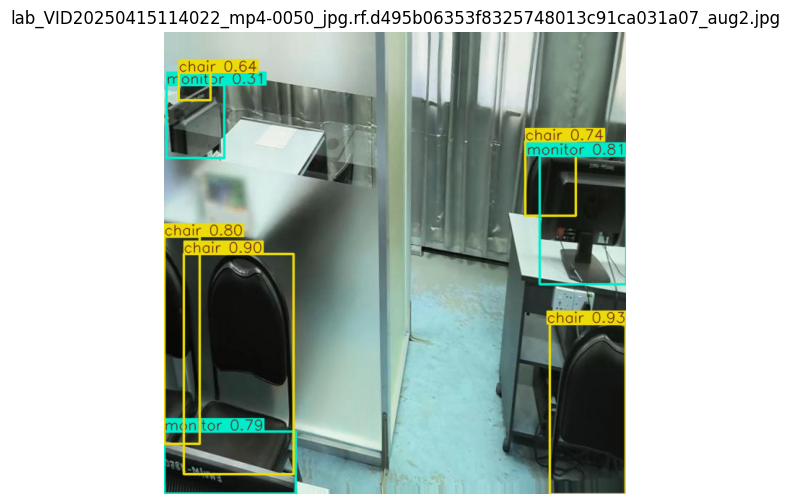


Изображение: lab_VID20250415111527_mp4-0042_jpg.rf.02e3d22277e6fea151708ca96cc5fc05.jpg


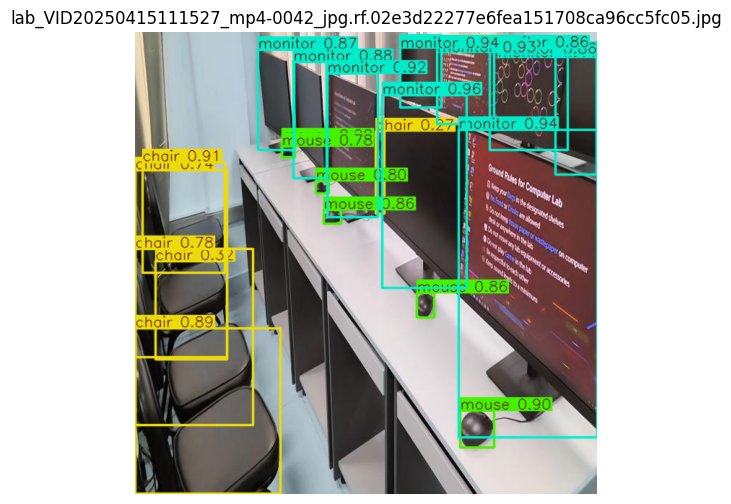


Изображение: lab_VID20250415110740_mp4-0025_jpg.rf.2f4a7b037d7ee9ec1123c340378051aa_aug2.jpg


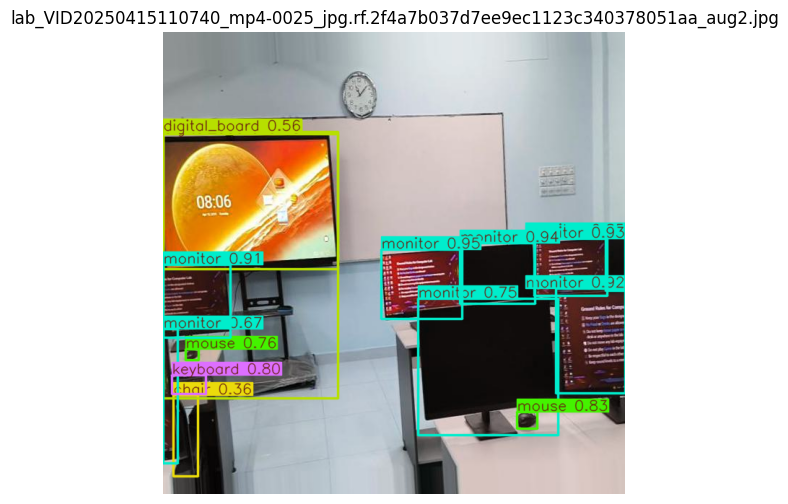


Изображение: ew_test_battery_battery_259.jpg


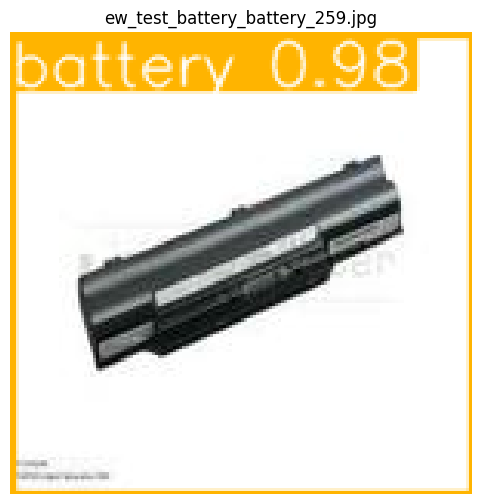

In [17]:
# Визуализация нескольких предсказаний на тестовых изображениях
import random
import matplotlib.pyplot as plt
import numpy as np

test_images_dir = COMBINED_ROOT / "images" / "test"

# Собираем список изображений (берём самые распространённые расширения)
test_image_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
    test_image_paths.extend(test_images_dir.glob(ext))

if not test_image_paths:
    raise RuntimeError(f"В {test_images_dir} не найдено ни одного изображения.")

# Выберем несколько случайных картинок
num_samples = 4
sample_paths = random.sample(test_image_paths, k=min(num_samples, len(test_image_paths)))

print(f"Покажем примеры предсказаний для {len(sample_paths)} тестовых изображений.")

for img_path in sample_paths:
    print("\nИзображение:", img_path.name)
    results = best_model(str(img_path), imgsz=IMG_SIZE, device=device, verbose=False)

    # results[0].plot() возвращает изображение с нарисованными боксами (numpy array)
    vis_img = results[0].plot()

    plt.figure(figsize=(6, 6))
    plt.title(img_path.name)
    plt.axis("off")
    # OpenCV/YOLO обычно используют BGR, но plot уже выдаёт в формате для визуализации
    plt.imshow(vis_img)
    plt.show()

### Шаг 5. Анализ обучения и построение графиков

На этом шаге мы:

1. Подгружаем результаты эксперимента `yolov8n_combined_v1` и отображаем
   стандартные графики Ultralytics:
   * `results.png` — динамика лоссов и метрик по эпохам;
   * `confusion_matrix*.png`, `P_curve.png`, `R_curve.png`, `F1_curve.png`, `PR_curve.png`.
2. Отдельно отображаем графики из директории `runs/detect/val` для тестового сплита.
3. Строим собственные графики по `results.csv`:
   * потери `box_loss`, `cls_loss`, `dfl_loss` (train/val);
   * метрики `precision`, `recall`, `mAP50`, `mAP50–95` по эпохам.

Эти визуализации потом можно вставлять в отчёт (как минимум общие кривые обучения и PR/F1-кривые).

Каталог обучения: /content/computer_lab_detector/runs/yolov8n_combined_v1

 Кривые обучения (results.png)


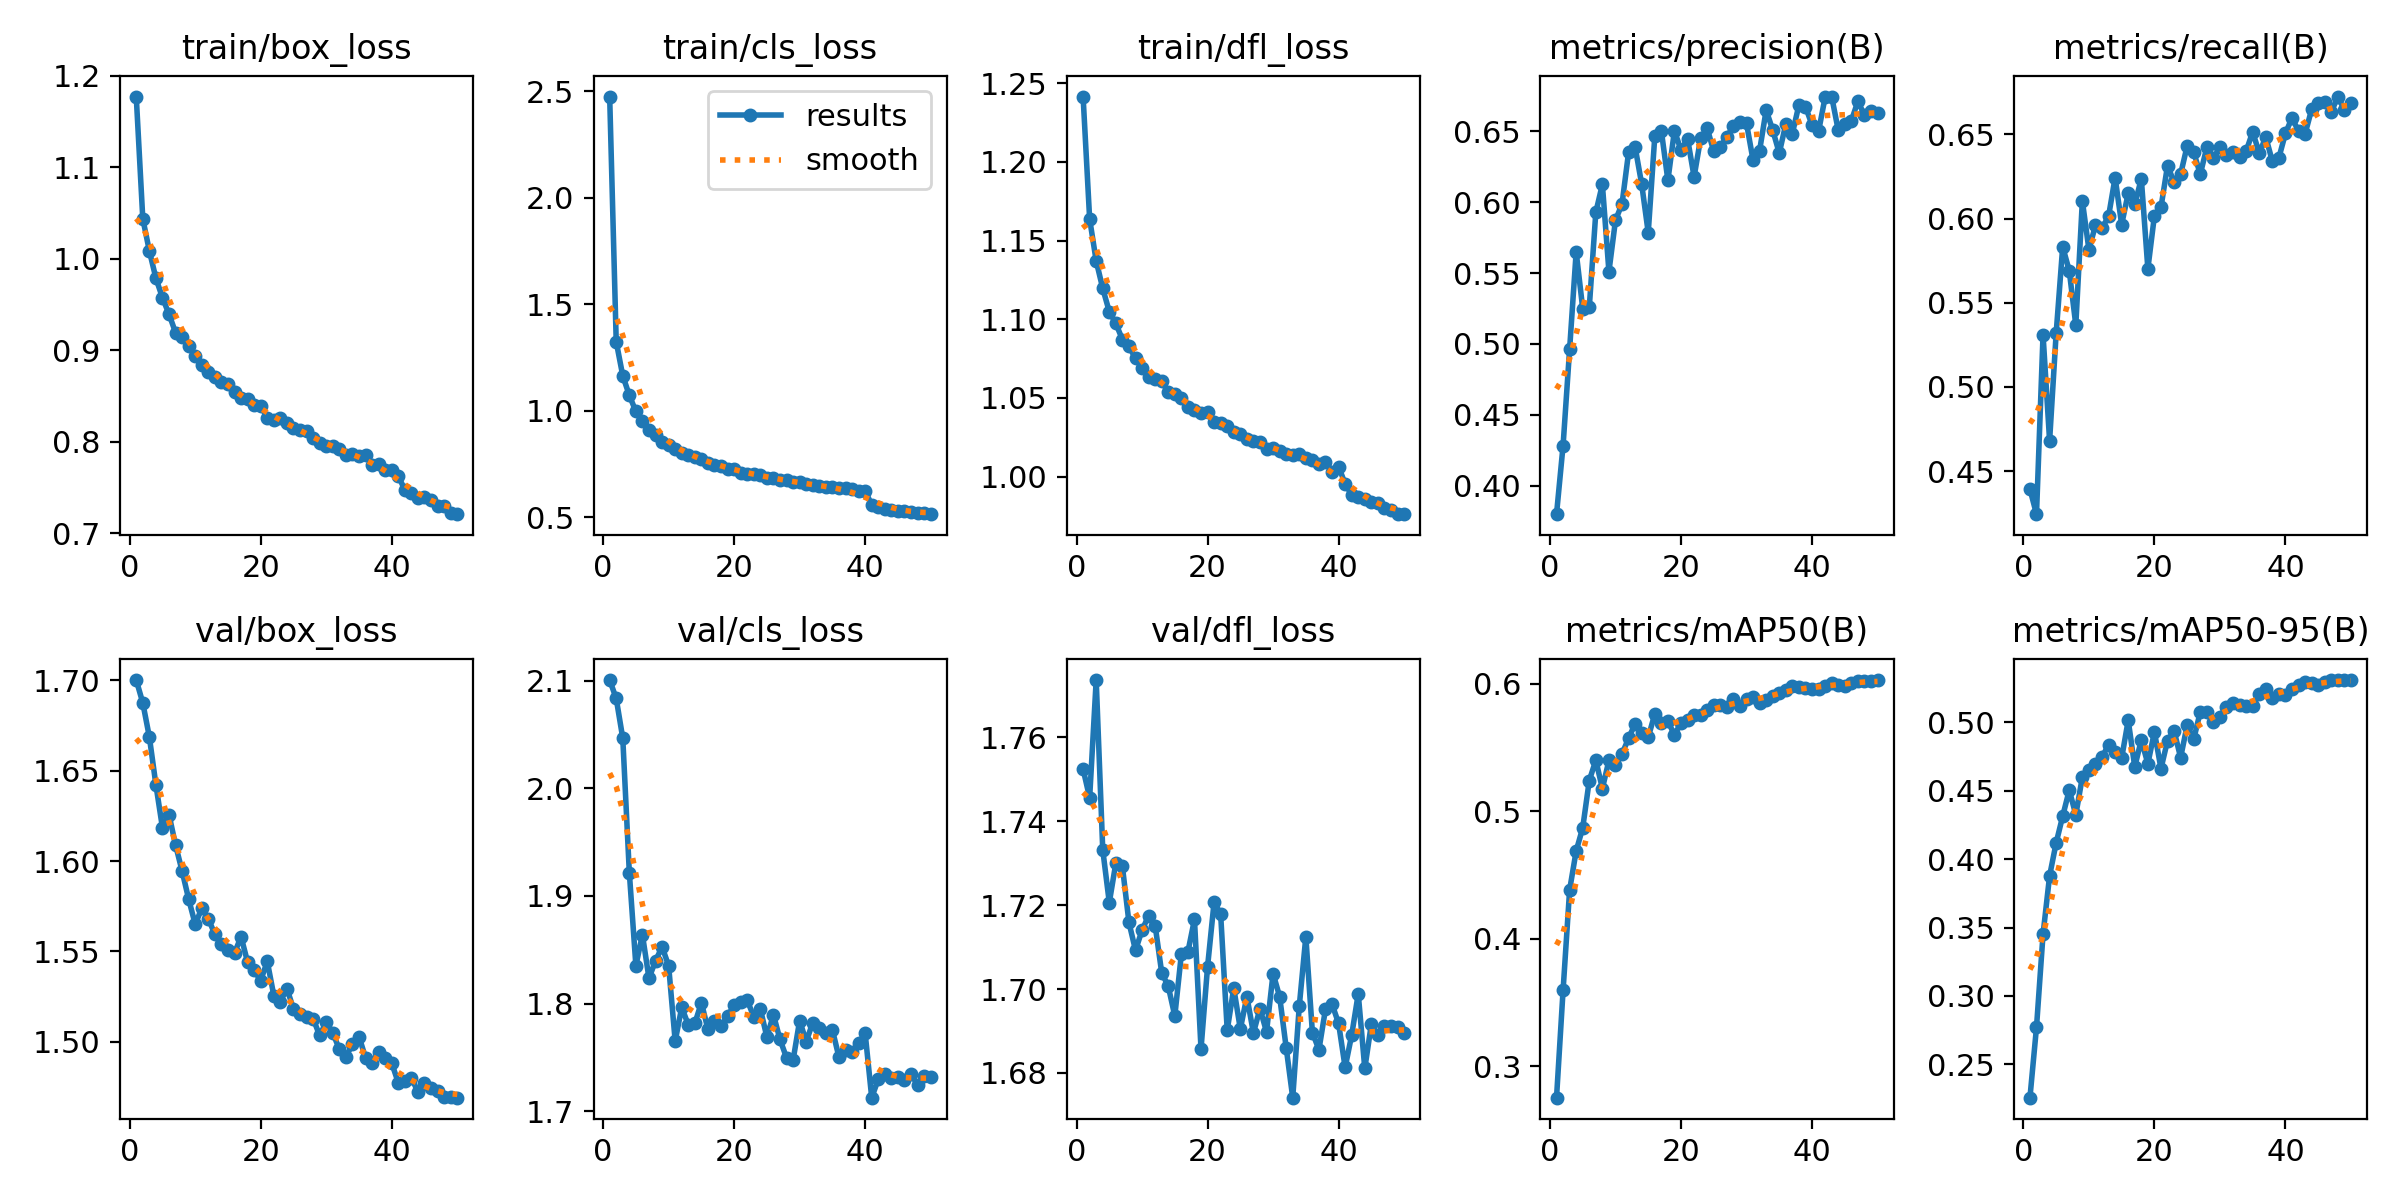


 Матрица ошибок (сырые значения)


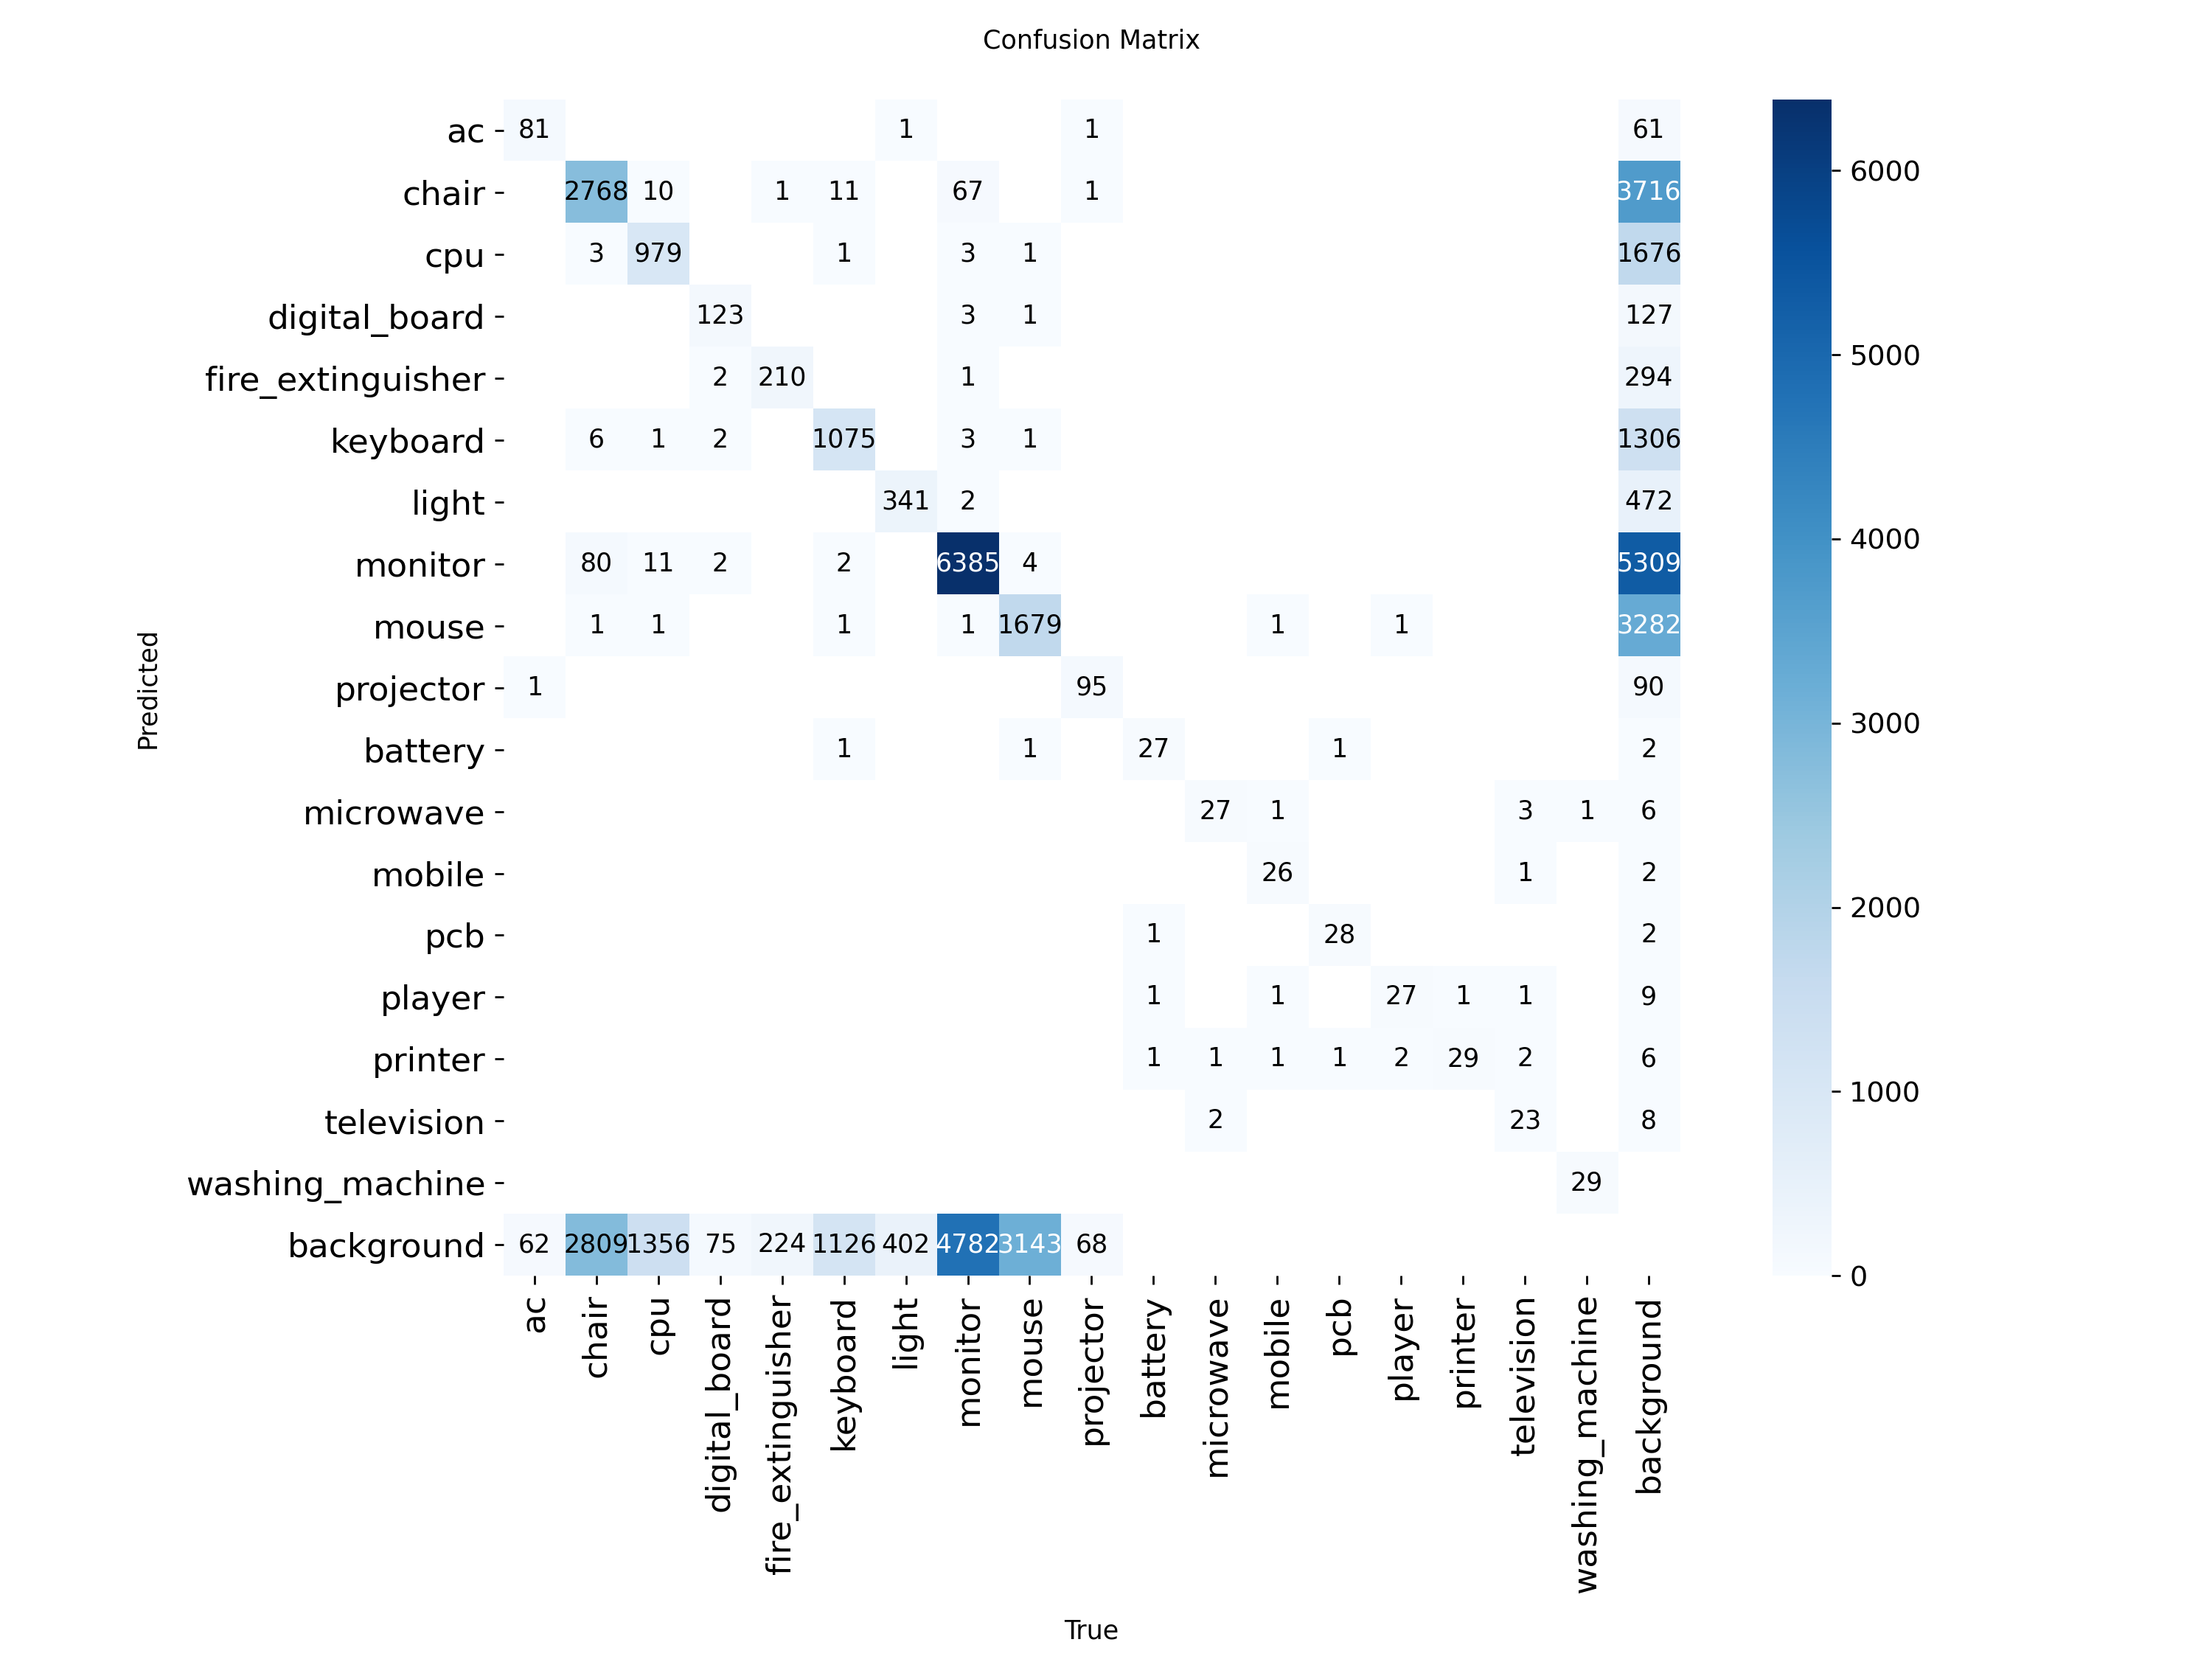


 Матрица ошибок (нормированная)


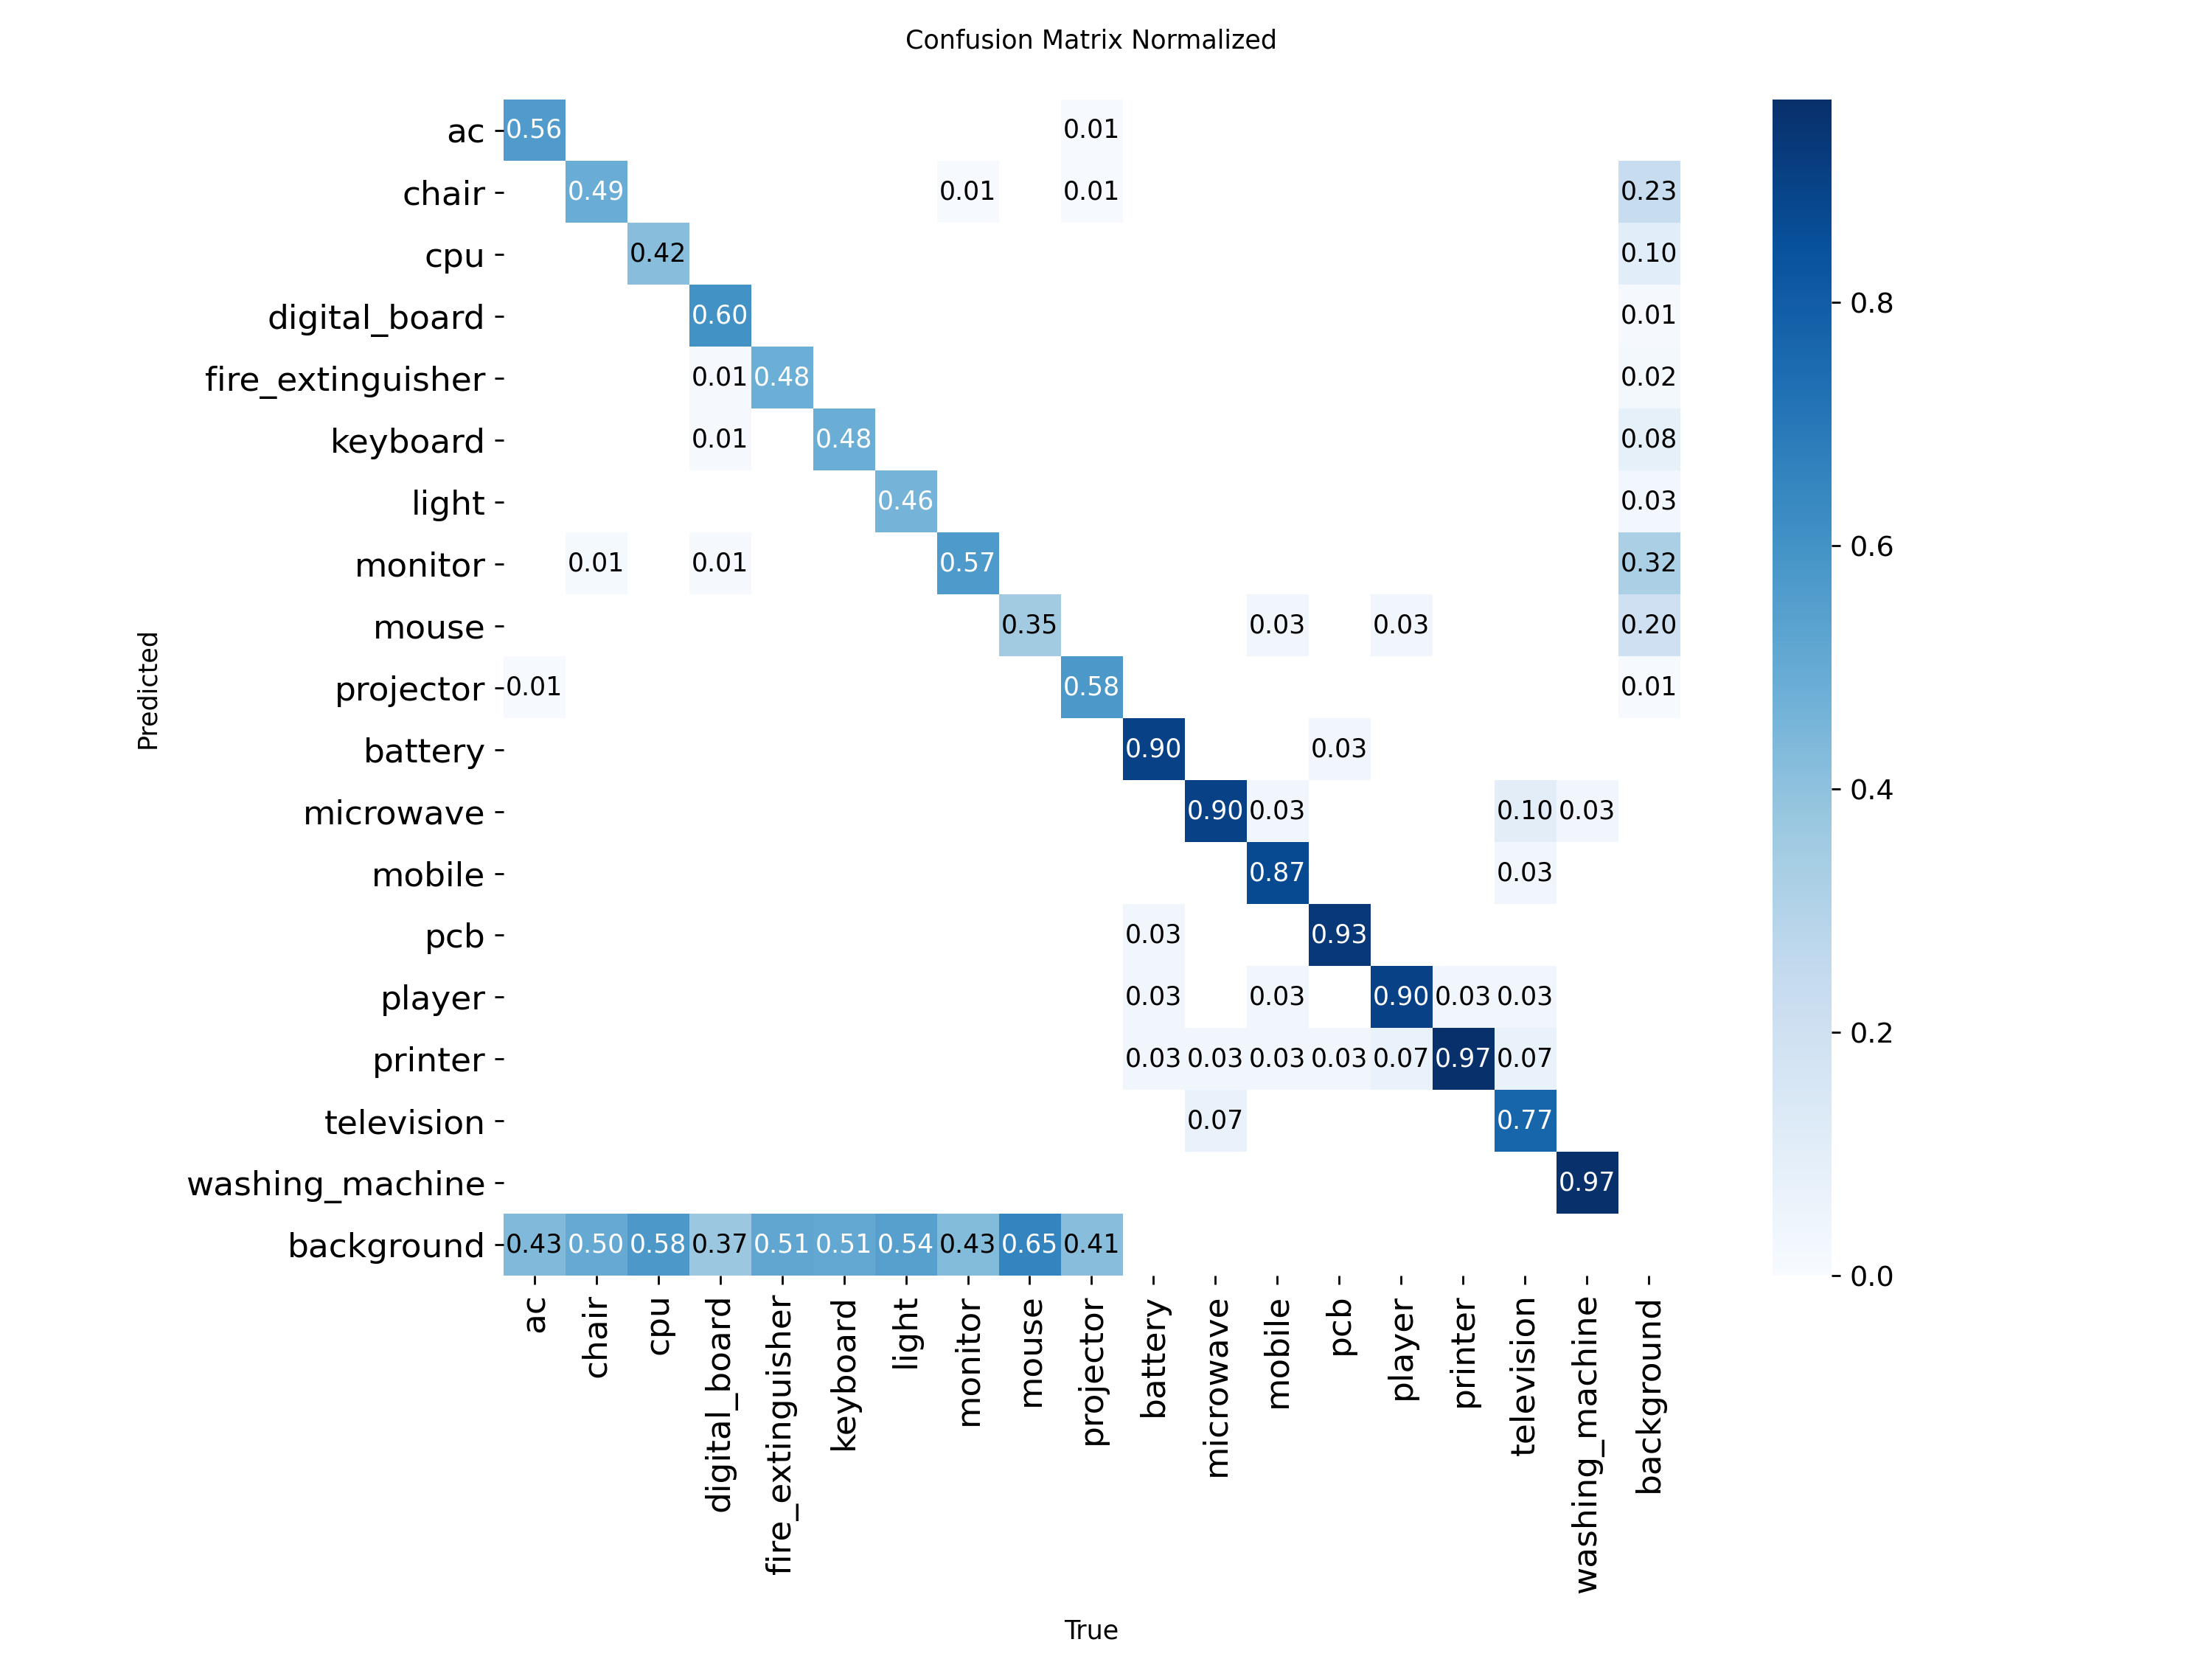

[WARN] Файл не найден: /content/computer_lab_detector/runs/yolov8n_combined_v1/P_curve.png
[WARN] Файл не найден: /content/computer_lab_detector/runs/yolov8n_combined_v1/R_curve.png
[WARN] Файл не найден: /content/computer_lab_detector/runs/yolov8n_combined_v1/F1_curve.png
[WARN] Файл не найден: /content/computer_lab_detector/runs/yolov8n_combined_v1/PR_curve.png


In [21]:
# Путь к эксперименту и стандартные графики Ultralytics
from pathlib import Path
from IPython.display import Image, display

# Базовые пути (если ядро перезапускалось)
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path("/content") / "computer_lab_detector"

RUNS_DIR = PROJECT_ROOT / "runs"

# Каталог обучения
train_run_dir = RUNS_DIR / "yolov8n_combined_v1"
if not train_run_dir.exists():
    raise FileNotFoundError(f"Каталог эксперимента не найден: {train_run_dir}")

print("Каталог обучения:", train_run_dir)

def show_if_exists(path: Path, title: str = None):
    """Удобная функция: показываем картинку, если она существует."""
    if path.exists():
        if title:
            print("\n", title)
        display(Image(filename=str(path)))
    else:
        print(f"[WARN] Файл не найден: {path}")


# 1) Общие результаты обучения (лоссы и метрики по эпохам)
show_if_exists(train_run_dir / "results.png", "Кривые обучения (results.png)")

# 2) Матрицы ошибок
show_if_exists(train_run_dir / "confusion_matrix.png", "Матрица ошибок (сырые значения)")
show_if_exists(train_run_dir / "confusion_matrix_normalized.png", "Матрица ошибок (нормированная)")

# 3) Кривые P/R/F1/PR
show_if_exists(train_run_dir / "P_curve.png", "P-curve (precision vs threshold)")
show_if_exists(train_run_dir / "R_curve.png", "R-curve (recall vs threshold)")
show_if_exists(train_run_dir / "F1_curve.png", "F1-curve (F1 vs threshold)")
show_if_exists(train_run_dir / "PR_curve.png", "PR-curve (precision–recall)")

Каталог результатов на test-сплите: /content/computer_lab_detector/runs/detect/val
[WARN] Файл не найден: /content/computer_lab_detector/runs/detect/val/results.png

 Матрица ошибок (test)


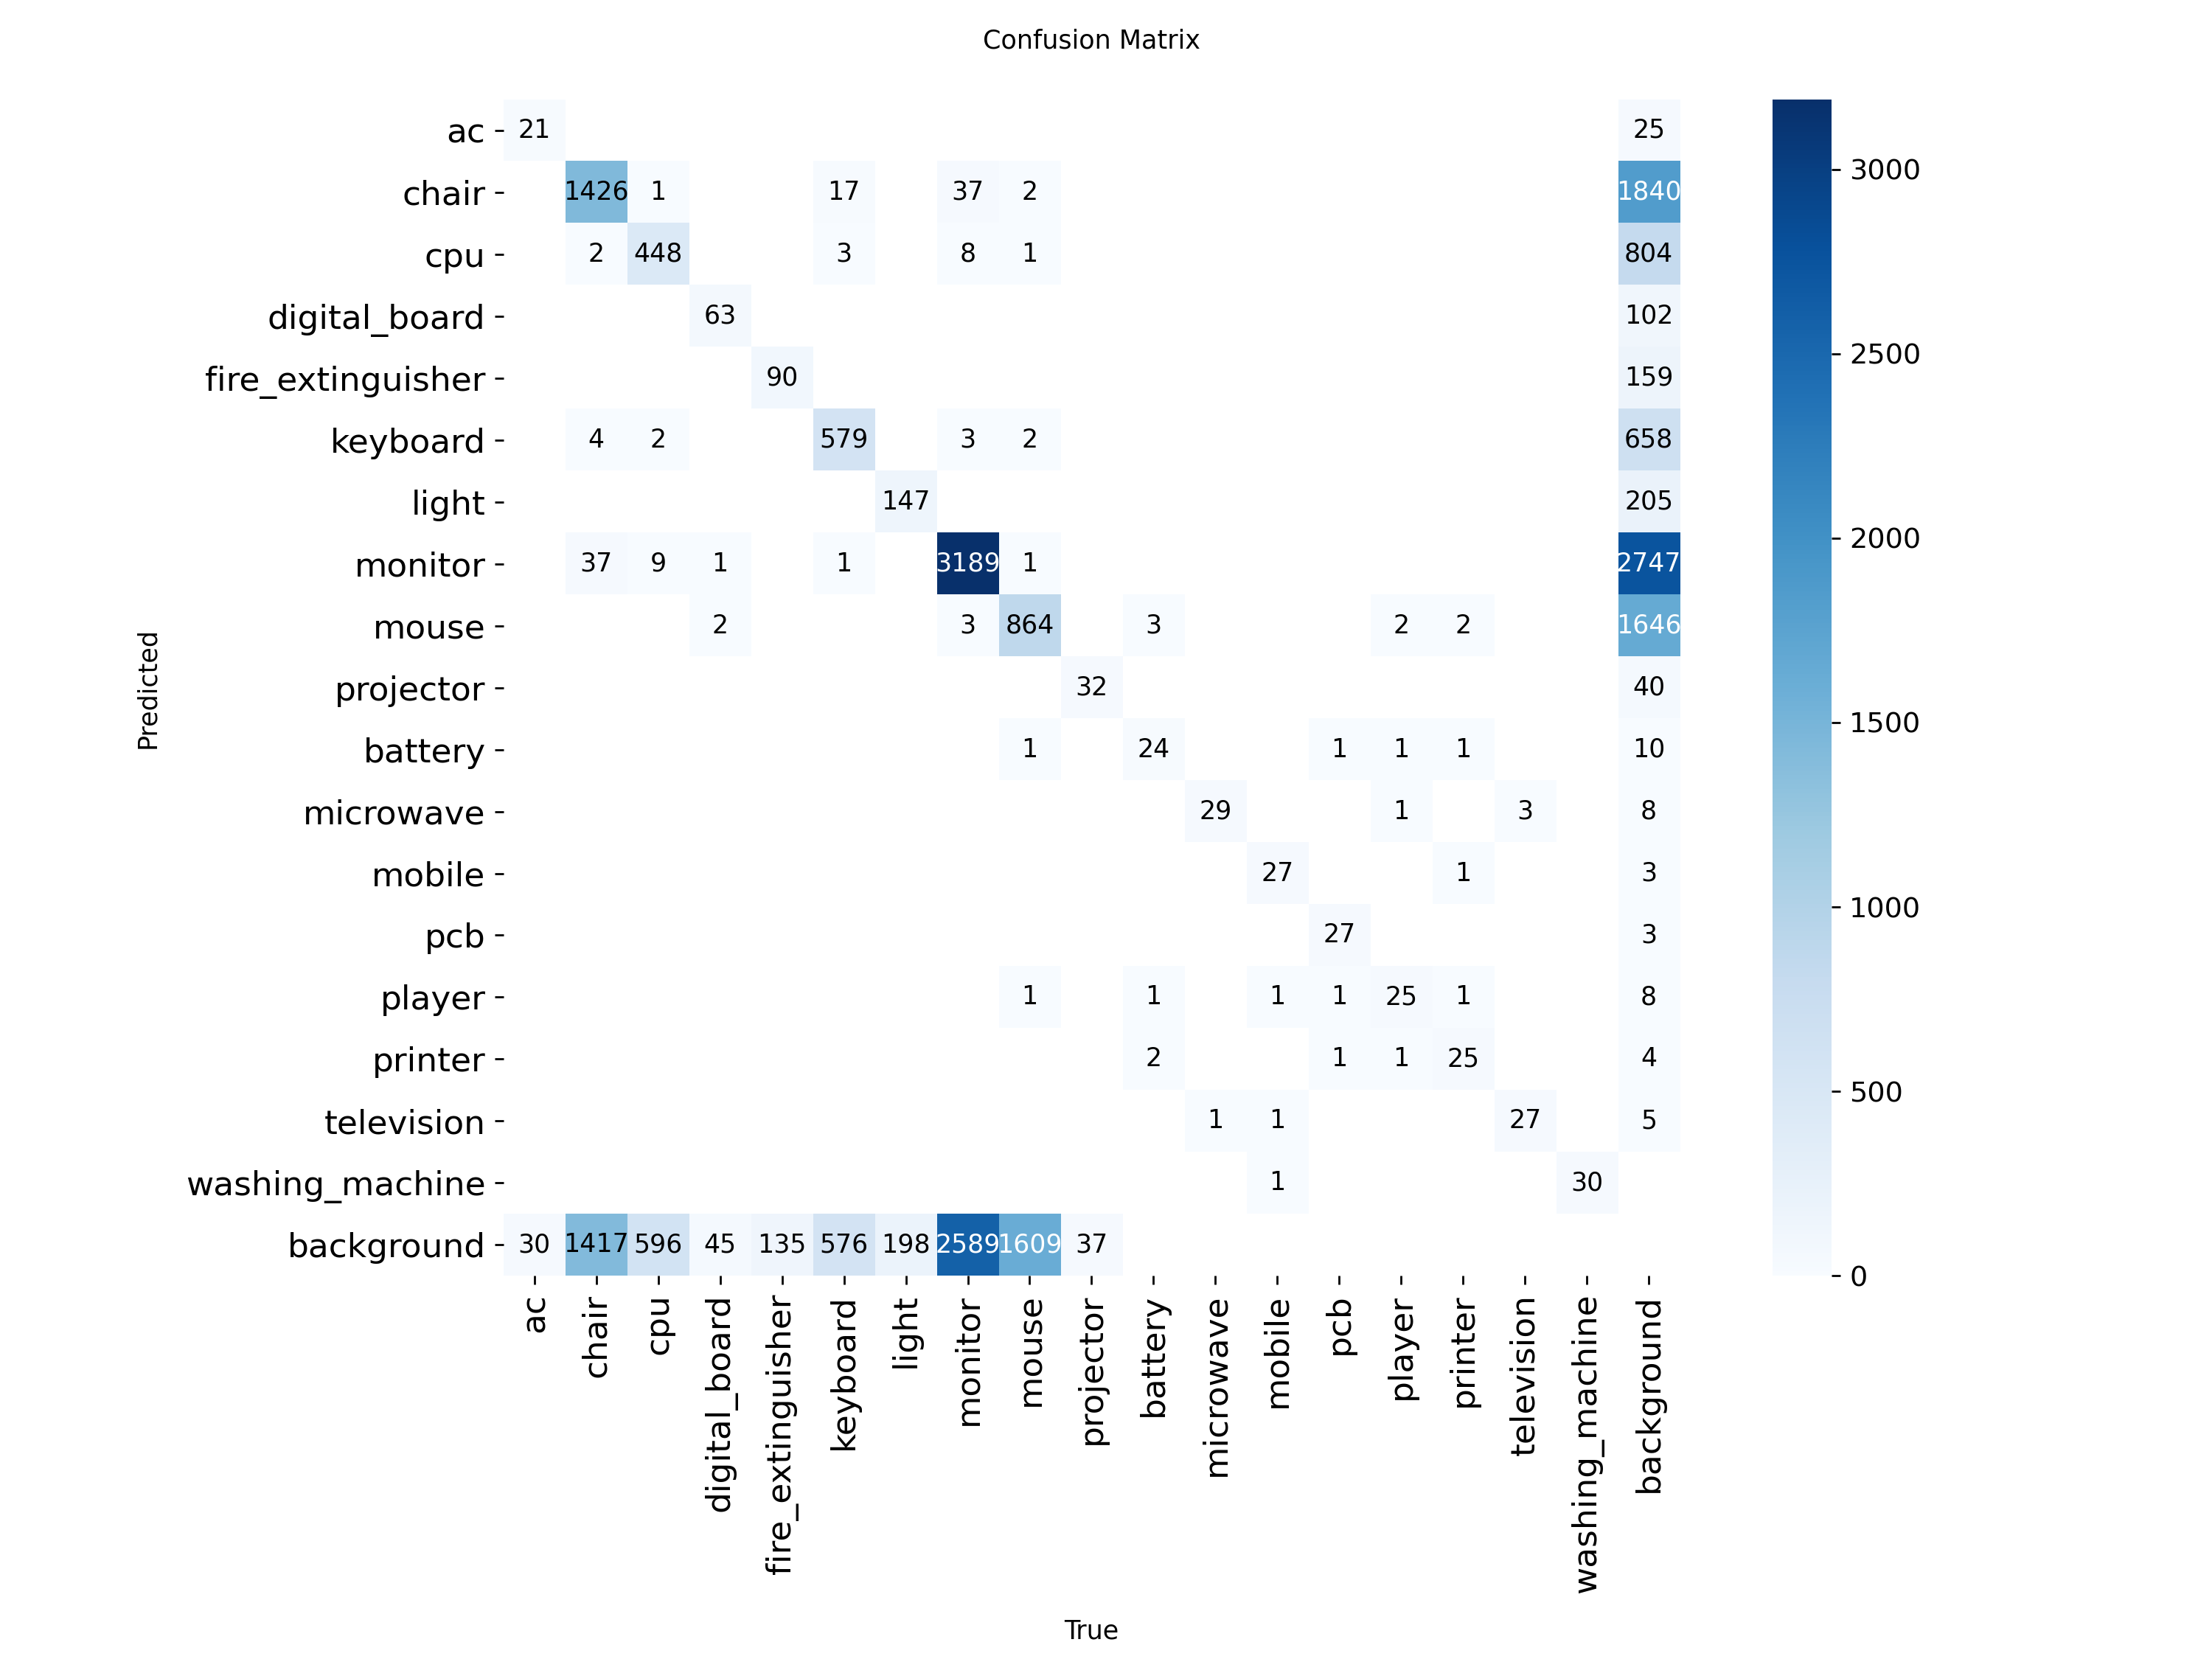


 Матрица ошибок (test, нормированная)


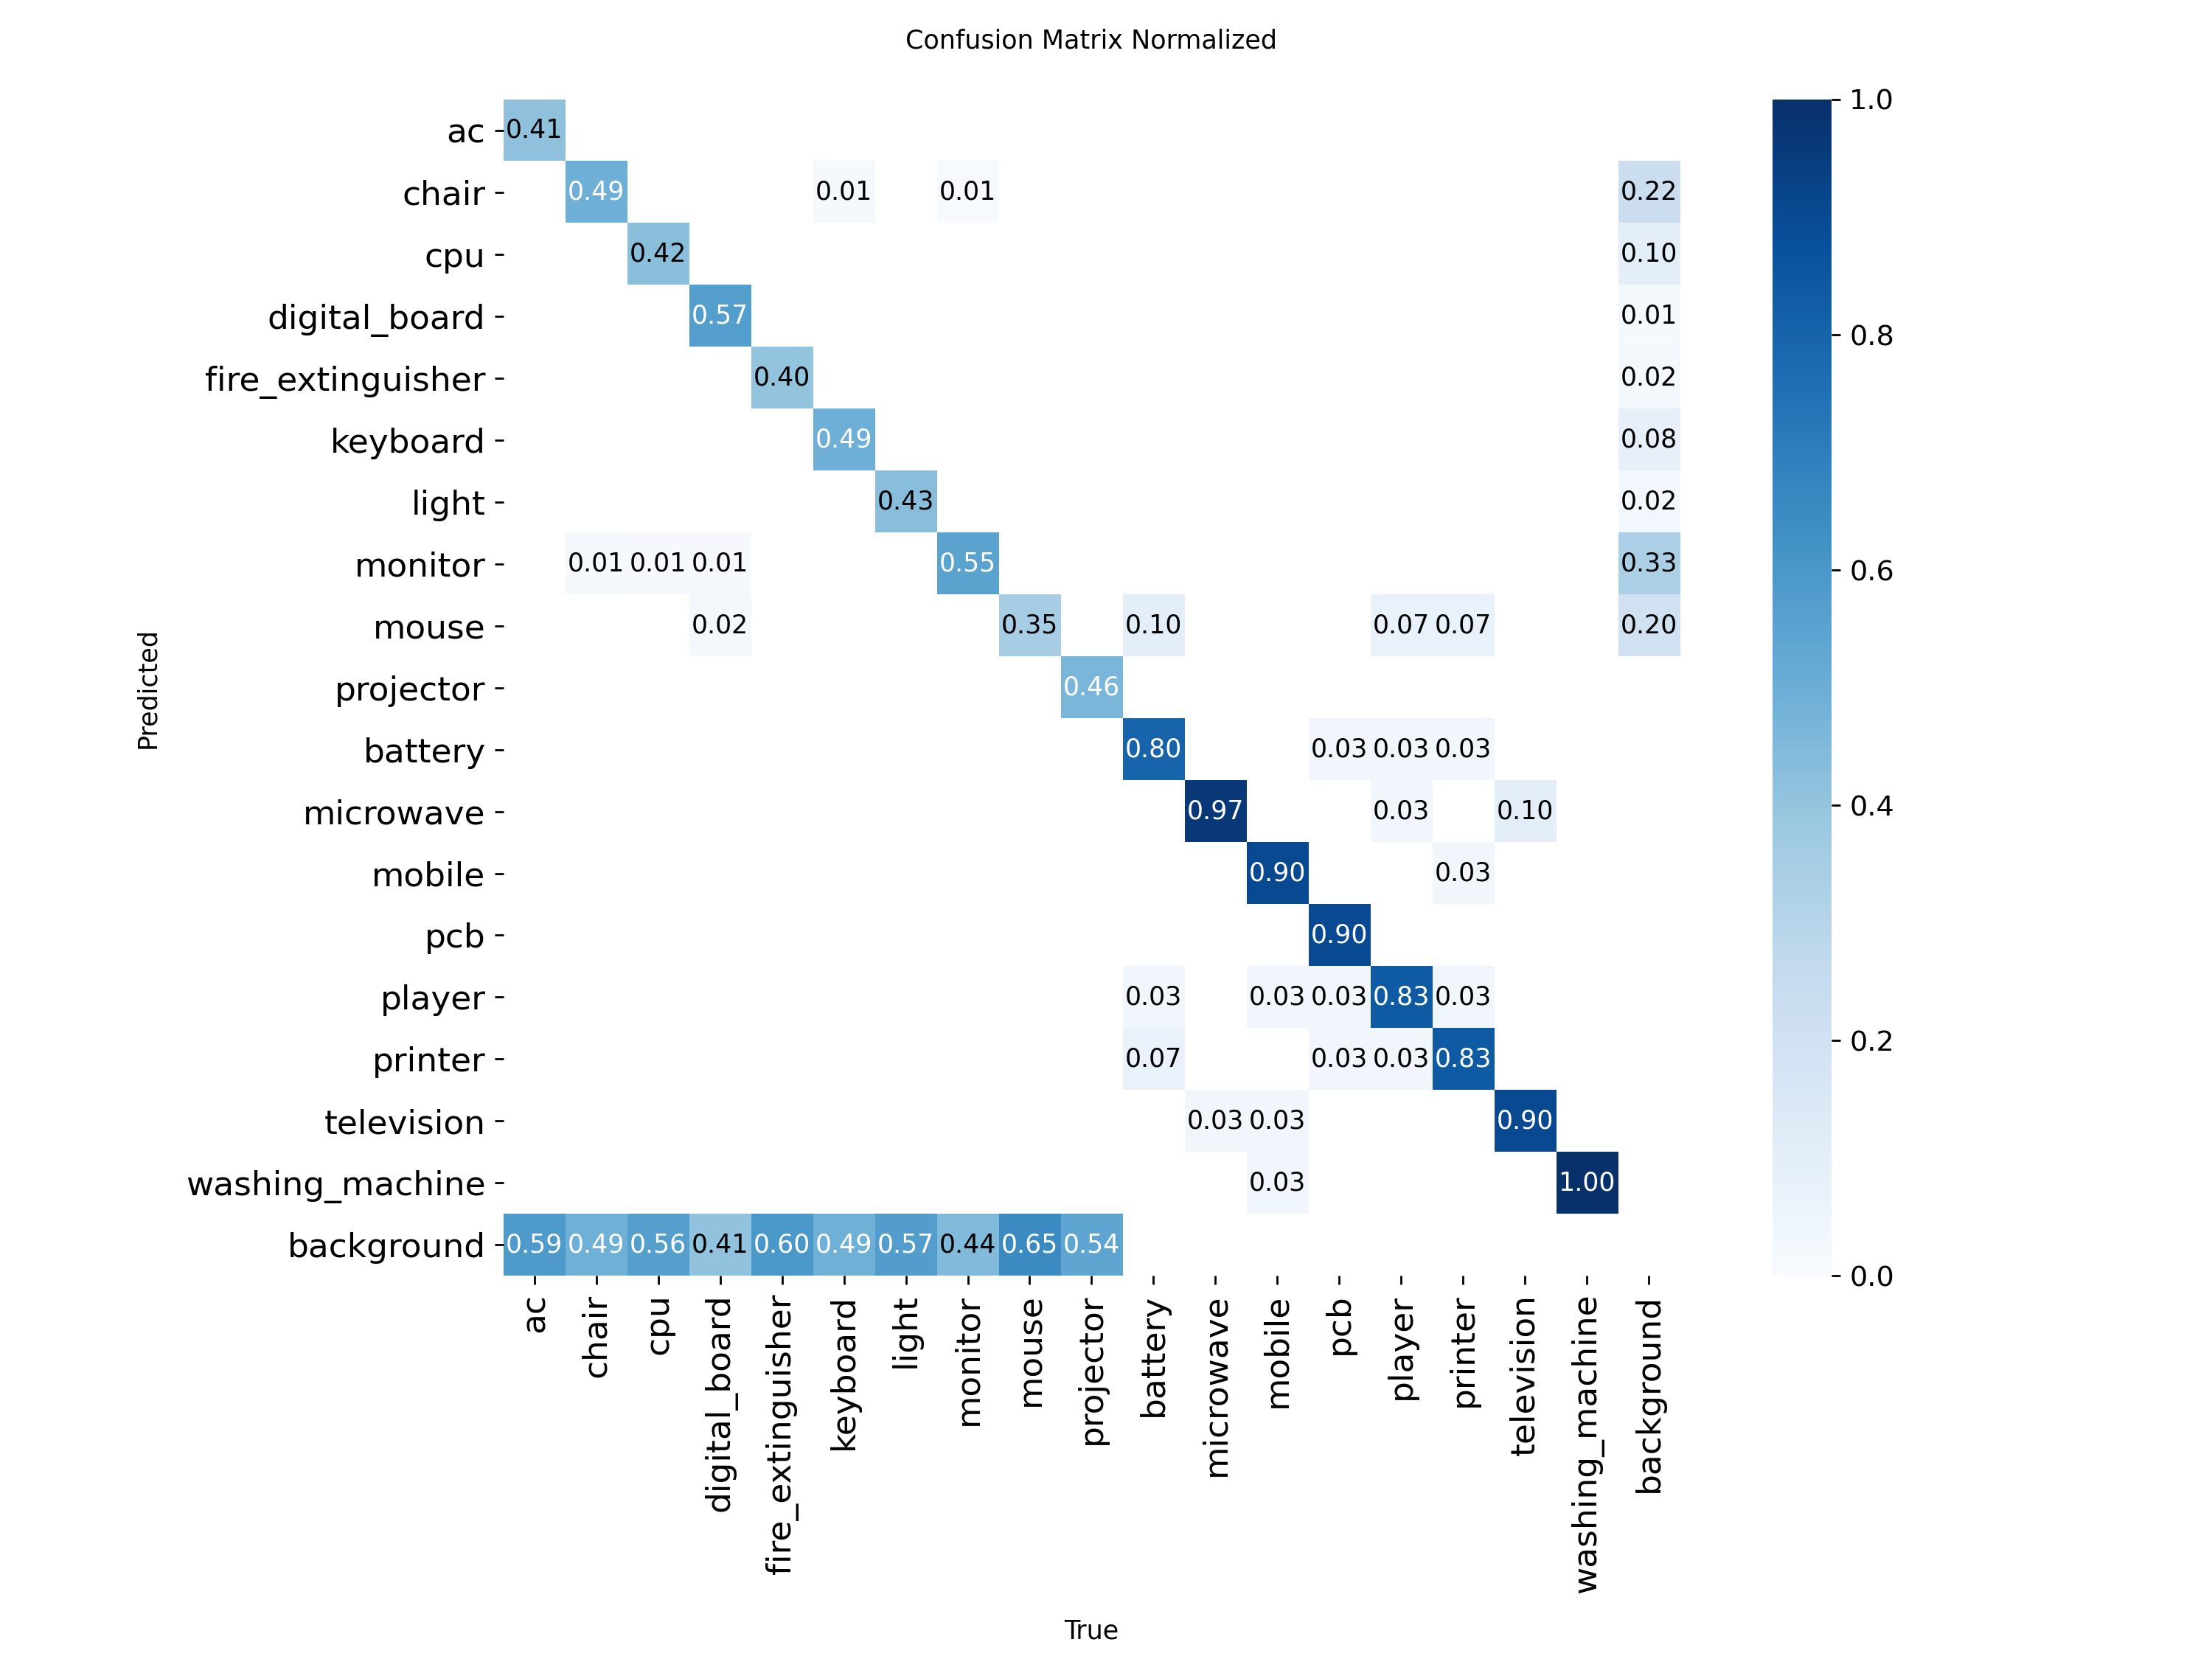

[WARN] Файл не найден: /content/computer_lab_detector/runs/detect/val/PR_curve.png
[WARN] Файл не найден: /content/computer_lab_detector/runs/detect/val/F1_curve.png


In [22]:
# Графики для тестового сплита (runs/detect/val)
detect_val_dir = RUNS_DIR / "detect" / "val"
print("Каталог результатов на test-сплите:", detect_val_dir)

show_if_exists(detect_val_dir / "results.png", "Результаты на test-сплите (results.png)")
show_if_exists(detect_val_dir / "confusion_matrix.png", "Матрица ошибок (test)")
show_if_exists(detect_val_dir / "confusion_matrix_normalized.png", "Матрица ошибок (test, нормированная)")
show_if_exists(detect_val_dir / "PR_curve.png", "PR-кривые по классам (test)")
show_if_exists(detect_val_dir / "F1_curve.png", "F1-кривые по классам (test)")

Столбцы results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


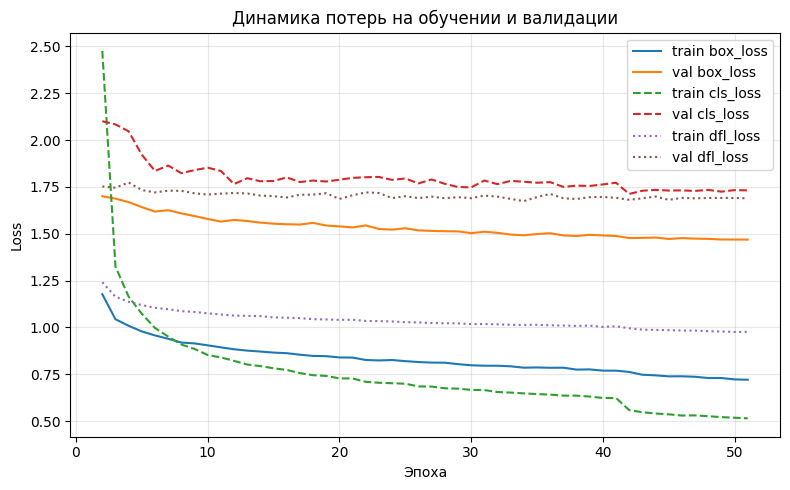

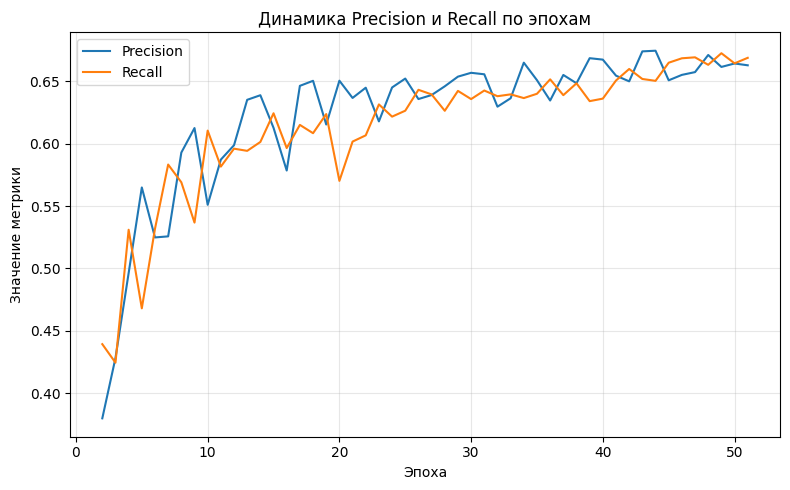

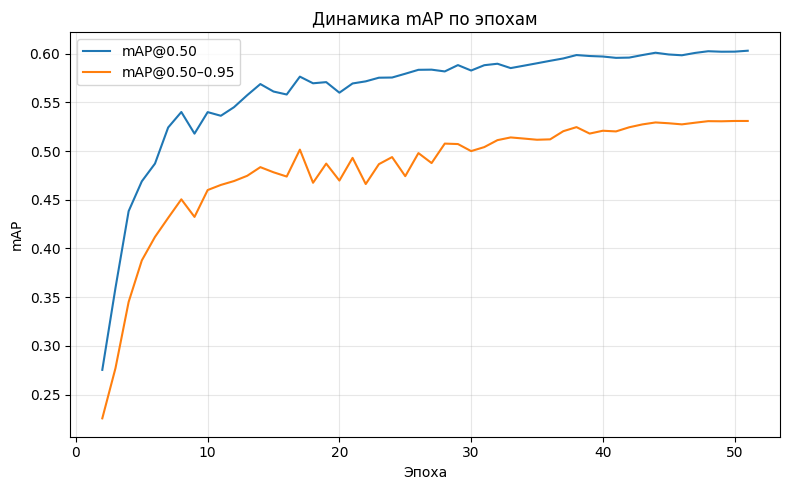

In [23]:
# Свои графики по results.csv: лоссы и метрики по эпохам
import pandas as pd
import matplotlib.pyplot as plt

results_csv = train_run_dir / "results.csv"
if not results_csv.exists():
    raise FileNotFoundError(f"Файл results.csv не найден: {results_csv}")

df = pd.read_csv(results_csv)
print("Столбцы results.csv:", list(df.columns))

# В YOLOv8 эпоха начинается с 0, для графиков удобнее +1
epochs = df["epoch"] + 1

# --------- Лоссы: box / cls / dfl ---------
plt.figure(figsize=(8, 5))
if "train/box_loss" in df.columns and "val/box_loss" in df.columns:
    plt.plot(epochs, df["train/box_loss"], label="train box_loss")
    plt.plot(epochs, df["val/box_loss"], label="val box_loss")
if "train/cls_loss" in df.columns and "val/cls_loss" in df.columns:
    plt.plot(epochs, df["train/cls_loss"], label="train cls_loss", linestyle="--")
    plt.plot(epochs, df["val/cls_loss"], label="val cls_loss", linestyle="--")
if "train/dfl_loss" in df.columns and "val/dfl_loss" in df.columns:
    plt.plot(epochs, df["train/dfl_loss"], label="train dfl_loss", linestyle=":")
    plt.plot(epochs, df["val/dfl_loss"], label="val dfl_loss", linestyle=":")

plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Динамика потерь на обучении и валидации")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Метрики: precision, recall ---------
plt.figure(figsize=(8, 5))
if "metrics/precision(B)" in df.columns:
    plt.plot(epochs, df["metrics/precision(B)"], label="Precision")
if "metrics/recall(B)" in df.columns:
    plt.plot(epochs, df["metrics/recall(B)"], label="Recall")
plt.xlabel("Эпоха")
plt.ylabel("Значение метрики")
plt.title("Динамика Precision и Recall по эпохам")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Метрики: mAP50 и mAP50-95 ---------
plt.figure(figsize=(8, 5))
if "metrics/mAP50(B)" in df.columns:
    plt.plot(epochs, df["metrics/mAP50(B)"], label="mAP@0.50")
if "metrics/mAP50-95(B)" in df.columns:
    plt.plot(epochs, df["metrics/mAP50-95(B)"], label="mAP@0.50–0.95")
plt.xlabel("Эпоха")
plt.ylabel("mAP")
plt.title("Динамика mAP по эпохам")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

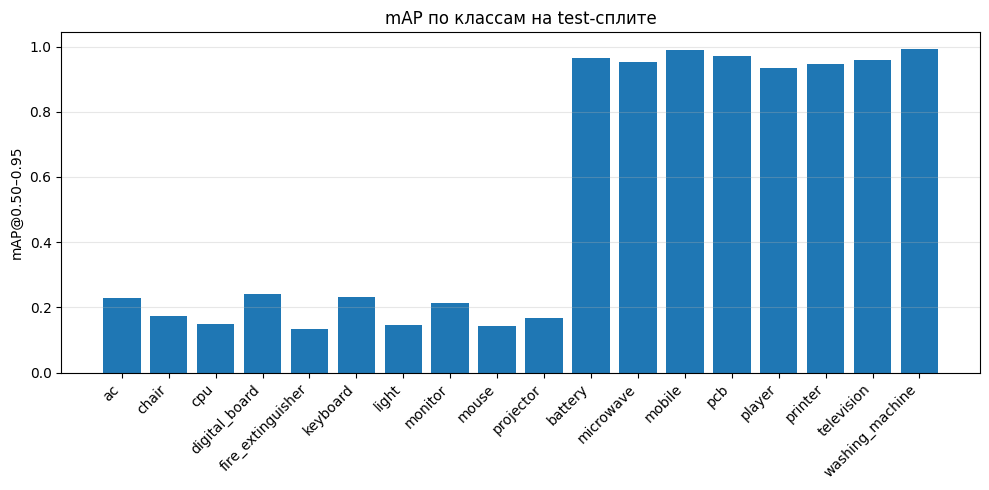

In [24]:
# Столбчатый график mAP50 по классам с тестового сплита

import numpy as np
import matplotlib.pyplot as plt

# Берём словарь per_class_metrics из последней валидации test.
try:
    test_results  # проверяем, существует ли объект
except NameError:
    from ultralytics import YOLO
    best_weights_path = MODELS_DIR / "yolov8n_combined_best.pt"
    if not best_weights_path.exists():
        raise FileNotFoundError(f"Не найдены финальные веса: {best_weights_path}")
    best_model = YOLO(str(best_weights_path))
    test_results = best_model.val(
        data=str(combined_yaml_path),
        split="test",
        imgsz=640,
        batch=16,
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False,
    )

# В новых версиях Ultralytics per-class AP хранятся в results.box.maps (mAP50-95 по классам)
per_class_map = getattr(test_results.box, "maps", None)
if per_class_map is None:
    print("Не удалось извлечь per-class mAP из объекта test_results.")
else:
    per_class_map = np.array(per_class_map)
    num_classes = len(per_class_map)
    indices = np.arange(num_classes)

    plt.figure(figsize=(10, 5))
    plt.bar(indices, per_class_map)
    plt.xticks(indices, class_names_list, rotation=45, ha="right")
    plt.ylabel("mAP@0.50–0.95")
    plt.title("mAP по классам на test-сплите")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()